# Dark Matter Index Analysis: Exploring Hash Diversity Patterns

## Hypothesis

The multi-modal distribution of alpha diversity vs hash density observed across metagenome samples may be explained by the **Dark Matter Index (DMI)** — the fraction of k-mer hashes in a sample that do not map to any reference database.

Specifically, we hypothesize that:
1. Samples with high hash density but low alpha diversity (the "outlier" clusters) have high DMI values
2. These samples contain substantial uncharacterized genetic material ("dark matter") that inflates hash counts without contributing to mapped species diversity
3. DMI varies systematically by organism type, with some environments (e.g., soil) harboring more unmapped diversity

## Analysis Overview

1. **Data Overview**: Load and explore the merged dataset
2. **DMI Distribution**: Understand the overall distribution of dark matter across samples
3. **DMI vs Hash Metrics Correlation**: Quantify relationships between DMI and hash density/diversity
4. **Organism-Stratified Analysis**: Reproduce hash-diversity plots with DMI coloring
5. **Top/Bottom Organisms**: Deep dive into organisms with highest/lowest DMI
6. **Outlier Investigation**: Directly test if circled outliers have elevated DMI
7. **Statistical Testing**: Formal hypothesis tests
8. **DMI per Mb Analysis**: Alternative normalization for DMI
9. **Outlier Metadata Enrichment**: What metadata variables characterize outliers?

In [1]:
# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import spearmanr, pearsonr, kendalltau, chi2_contingency, fisher_exact
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11

# For non-interactive backend (headless mode)
import matplotlib
# Uncomment the following line for headless execution:
# matplotlib.use('Agg')

print("Libraries loaded successfully")

Libraries loaded successfully


## 1. Configuration and Data Loading

In [52]:
# ============================================================
# CONFIGURATION - MODIFY THESE SETTINGS
# ============================================================

# Path to your merged parquet file
# hash threshold
#PARQUET_PATH = "/scratch/dmk333_new/Logan/Logan_Analyses/verify_diversity_correlation/data/hash_diversity_results_full_cov_0.0/analysis/filtered_analysis_min_hash_10000_min_diversity_10/filtered_data_with_dmi_merged.parquet"
# MB threshold
PARQUET_PATH = "/scratch/dmk333_new/Logan/Logan_Analyses/verify_diversity_correlation/data/hash_diversity_results_full_cov_0.0/analysis/filtered_analysis_min_mbases_1620_min_diversity_10/filtered_data_with_dmi_merged.parquet"

# ============================================================
# PLATFORM FILTER
# ============================================================
# Options:
#   'all'                           - Include all platforms
#   ['ILLUMINA']                    - Illumina only (short-read, low error)
#   ['ILLUMINA', 'ION_TORRENT']     - Short-read technologies only
#   ['ILLUMINA', 'BGISEQ', 'DNBSEQ'] - All short-read platforms
#   ['OXFORD_NANOPORE', 'PACBIO_SMRT'] - Long-read only (for comparison)
#
# IMPORTANT: Long-read platforms (ONT, PacBio) have higher error rates,
# which inflates DMI due to erroneous k-mers that don't map to references.
# For biological interpretation of DMI, restrict to short-read platforms.

PLATFORM_FILTER = ['ILLUMINA']  # Change this to customize
# PLATFORM_FILTER = ['ILLUMINA', 'ION_TORRENT']
# PLATFORM_FILTER = 'all'

print(f"Configuration:")
print(f"  PARQUET_PATH: {PARQUET_PATH}")
print(f"  PLATFORM_FILTER: {PLATFORM_FILTER}")

Configuration:
  PARQUET_PATH: /scratch/dmk333_new/Logan/Logan_Analyses/verify_diversity_correlation/data/hash_diversity_results_full_cov_0.0/analysis/filtered_analysis_min_mbases_1620_min_diversity_10/filtered_data_with_dmi_merged.parquet
  PLATFORM_FILTER: ['ILLUMINA']


In [53]:
# Load data
print(f"\nLoading data from: {PARQUET_PATH}")
df_raw = pd.read_parquet(PARQUET_PATH)
print(f"Raw dataset shape: {df_raw.shape[0]:,} samples × {df_raw.shape[1]} columns")

# Show platform distribution before filtering
print(f"\nPlatform distribution (before filtering):")
platform_counts = df_raw['platform'].value_counts()
for platform, count in platform_counts.items():
    print(f"  {platform}: {count:,} ({100*count/len(df_raw):.1f}%)")


Loading data from: /scratch/dmk333_new/Logan/Logan_Analyses/verify_diversity_correlation/data/hash_diversity_results_full_cov_0.0/analysis/filtered_analysis_min_mbases_1620_min_diversity_10/filtered_data_with_dmi_merged.parquet
Raw dataset shape: 201,059 samples × 29 columns

Platform distribution (before filtering):
  ILLUMINA: 192,893 (95.9%)
  BGISEQ: 3,000 (1.5%)
  ION_TORRENT: 1,752 (0.9%)
  DNBSEQ: 1,478 (0.7%)
  OXFORD_NANOPORE: 1,112 (0.6%)
  ABI_SOLID: 562 (0.3%)
  PACBIO_SMRT: 180 (0.1%)
  COMPLETE_GENOMICS: 81 (0.0%)
  LS454: 1 (0.0%)


In [54]:
# Apply platform filter
if PLATFORM_FILTER == 'all':
    df = df_raw.copy()
    print(f"\nUsing ALL platforms ({len(df):,} samples)")
else:
    df = df_raw[df_raw['platform'].isin(PLATFORM_FILTER)].copy()
    print(f"\nFiltered to platforms: {PLATFORM_FILTER}")
    print(f"Samples remaining: {len(df):,} ({100*len(df)/len(df_raw):.1f}% of original)")
    
    # Show what was removed
    removed = len(df_raw) - len(df)
    print(f"Samples removed: {removed:,}")

print(f"\nDataset shape after filtering: {df.shape[0]:,} samples × {df.shape[1]} columns")


Filtered to platforms: ['ILLUMINA']
Samples remaining: 192,893 (95.9% of original)
Samples removed: 8,166

Dataset shape after filtering: 192,893 samples × 29 columns


In [55]:
# Display column information
print("Columns in dataset:")
print("-" * 50)
for i, col in enumerate(df.columns):
    dtype = df[col].dtype
    non_null = df[col].notna().sum()
    print(f"{i+1:2}. {col:30} {str(dtype):15} ({non_null:,} non-null)")

Columns in dataset:
--------------------------------------------------
 1. accession                      object          (192,893 non-null)
 2. hashes_per_mb                  float64         (192,893 non-null)
 3. total_distinct_hashes          int64           (192,893 non-null)
 4. diversity_per_mb               float64         (192,893 non-null)
 5. alpha_diversity                int64           (192,893 non-null)
 6. mbases_x                       int32           (192,893 non-null)
 7. biosample                      object          (192,893 non-null)
 8. organism                       object          (192,893 non-null)
 9. instrument                     object          (192,893 non-null)
10. platform                       object          (192,893 non-null)
11. sra_study                      object          (192,814 non-null)
12. bioproject                     object          (192,793 non-null)
13. center_name                    object          (192,893 non-null)
14. librarylayout  

In [56]:
# Key columns for analysis
key_columns = ['accession', 'hashes_per_mb', 'total_distinct_hashes', 'diversity_per_mb', 
               'alpha_diversity', 'mbases_x', 'dmi', 'total_hashes_dmi', 'unmapped_hashes', 
               'mapped_hashes', 'organism']

# Check which key columns exist
available_keys = [c for c in key_columns if c in df.columns]
missing_keys = [c for c in key_columns if c not in df.columns]

if missing_keys:
    print(f"Warning: Missing expected columns: {missing_keys}")

# Display summary statistics for numeric columns
numeric_cols = ['hashes_per_mb', 'diversity_per_mb', 'alpha_diversity', 'dmi', 
                'total_distinct_hashes', 'unmapped_hashes', 'mapped_hashes']
numeric_cols = [c for c in numeric_cols if c in df.columns]

print("\nSummary Statistics for Key Numeric Columns:")
print("=" * 80)
df[numeric_cols].describe().round(4)


Summary Statistics for Key Numeric Columns:


hashes_per_mb  diversity_per_mb  alpha_diversity          dmi  \
count    192893.0000       192893.0000      192893.0000  192893.0000   
mean         66.0631            0.4738        3167.9694       0.2830   
std          44.5248            0.3910        3446.4974       0.2641   
min           0.4077            0.0011          10.0000       0.0003   
25%          31.3756            0.1899        1052.0000       0.0610   
50%          55.7900            0.3857        2220.0000       0.1744   
75%          92.7617            0.6476        3699.0000       0.4749   
max         359.0997            4.1175       40039.0000       0.9974   

       total_distinct_hashes  unmapped_hashes  mapped_hashes  
count           1.928930e+05     1.928930e+05   1.928930e+05  
mean            5.542702e+05     2.473845e+05   3.068856e+05  
std             8.437256e+05     6.543275e+05   3.193197e+05  
min             1.843000e+03     2.400000e+01   9.100000e+01  
25%             1.567890e+05     1.363000e+04   1.112610e+05  
50%             2.998000e+05     3.311400e+04   2.245090e+05  
75%             5.682990e+05     1.618320e+05   3.850860e+05  
max             3.210690e+07     2.640130e+07   7.308805e+06

In [57]:
# Check DMI coverage
n_total = len(df)
n_with_dmi = df['dmi'].notna().sum()
n_without_dmi = n_total - n_with_dmi

print(f"DMI Coverage:")
print(f"  Total samples: {n_total:,}")
print(f"  With DMI: {n_with_dmi:,} ({100*n_with_dmi/n_total:.2f}%)")
print(f"  Without DMI: {n_without_dmi:,} ({100*n_without_dmi/n_total:.2f}%)")

# Filter to samples with DMI for subsequent analysis
df_dmi = df[df['dmi'].notna()].copy()
print(f"\nUsing {len(df_dmi):,} samples with DMI values for analysis")

DMI Coverage:
  Total samples: 192,893
  With DMI: 192,893 (100.00%)
  Without DMI: 0 (0.00%)

Using 192,893 samples with DMI values for analysis


In [58]:
# ============================================================
# COMPUTE DMI PER MB (alternative normalization)
# ============================================================
# Original DMI = unmapped_hashes / total_hashes (proportion)
# DMI per Mb = unmapped_hashes / mbases (density, like hashes_per_mb)
#
# This alternative normalization accounts for sample size differences
# and may reveal different patterns than the proportion-based DMI.

# Determine which mbases column to use
if 'mbases_x' in df_dmi.columns:
    mbases_col = 'mbases_x'
elif 'mbases' in df_dmi.columns:
    mbases_col = 'mbases'
else:
    raise ValueError("No mbases column found!")

print(f"Using '{mbases_col}' for size normalization")

# Compute normalized metrics
df_dmi['unmapped_per_mb'] = df_dmi['unmapped_hashes'] / df_dmi[mbases_col]
df_dmi['mapped_per_mb'] = df_dmi['mapped_hashes'] / df_dmi[mbases_col]

# Summary of new metrics
print("\nNew normalized metrics:")
print(f"  unmapped_per_mb: median={df_dmi['unmapped_per_mb'].median():.2f}, mean={df_dmi['unmapped_per_mb'].mean():.2f}")
print(f"  mapped_per_mb: median={df_dmi['mapped_per_mb'].median():.2f}, mean={df_dmi['mapped_per_mb'].mean():.2f}")

# Sanity check: unmapped_per_mb + mapped_per_mb should equal hashes_per_mb
check_sum = df_dmi['unmapped_per_mb'] + df_dmi['mapped_per_mb']
diff = (check_sum - df_dmi['hashes_per_mb']).abs().max()
print(f"\nSanity check (unmapped + mapped = total):")
print(f"  Max difference from hashes_per_mb: {diff:.6f}")
if diff < 0.01:
    print("  ✓ Check passed")
else:
    print("  ⚠ Check failed - investigate data")

Using 'mbases_x' for size normalization

New normalized metrics:
  unmapped_per_mb: median=5.65, mean=21.57
  mapped_per_mb: median=38.53, mean=44.49

Sanity check (unmapped + mapped = total):
  Max difference from hashes_per_mb: 0.000000
  ✓ Check passed


## 2. DMI Distribution Analysis

Understanding the overall distribution of Dark Matter Index values across all samples.

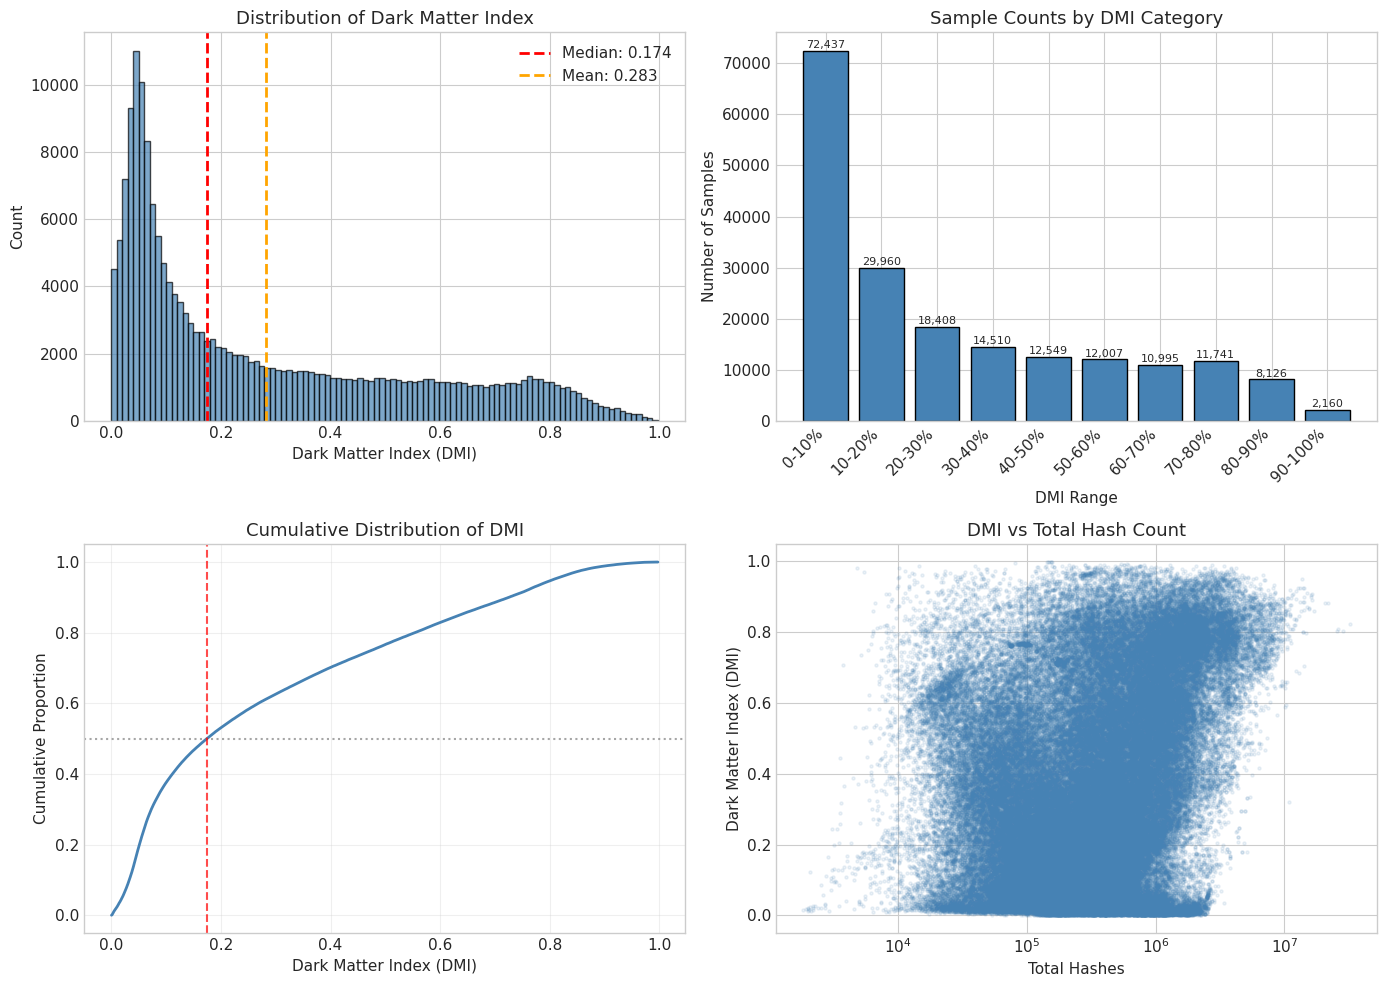


Figure saved: dmi_distribution_overview.png


In [59]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 2a. Histogram of DMI
ax = axes[0, 0]
ax.hist(df_dmi['dmi'], bins=100, edgecolor='black', alpha=0.7, color='steelblue')
ax.axvline(df_dmi['dmi'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {df_dmi["dmi"].median():.3f}')
ax.axvline(df_dmi['dmi'].mean(), color='orange', linestyle='--', linewidth=2, label=f'Mean: {df_dmi["dmi"].mean():.3f}')
ax.set_xlabel('Dark Matter Index (DMI)')
ax.set_ylabel('Count')
ax.set_title('Distribution of Dark Matter Index')
ax.legend()

# 2b. Box plot by DMI category
ax = axes[0, 1]
df_dmi['dmi_category'] = pd.cut(df_dmi['dmi'], 
                                 bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                 labels=['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', 
                                        '50-60%', '60-70%', '70-80%', '80-90%', '90-100%'])
category_counts = df_dmi['dmi_category'].value_counts().sort_index()
bars = ax.bar(range(len(category_counts)), category_counts.values, color='steelblue', edgecolor='black')
ax.set_xticks(range(len(category_counts)))
ax.set_xticklabels(category_counts.index, rotation=45, ha='right')
ax.set_xlabel('DMI Range')
ax.set_ylabel('Number of Samples')
ax.set_title('Sample Counts by DMI Category')

# Add count labels on bars
for bar, count in zip(bars, category_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100, 
            f'{count:,}', ha='center', va='bottom', fontsize=8)

# 2c. Cumulative distribution
ax = axes[1, 0]
sorted_dmi = np.sort(df_dmi['dmi'])
cumulative = np.arange(1, len(sorted_dmi) + 1) / len(sorted_dmi)
ax.plot(sorted_dmi, cumulative, linewidth=2, color='steelblue')
ax.axhline(0.5, color='gray', linestyle=':', alpha=0.7)
ax.axvline(df_dmi['dmi'].median(), color='red', linestyle='--', alpha=0.7)
ax.set_xlabel('Dark Matter Index (DMI)')
ax.set_ylabel('Cumulative Proportion')
ax.set_title('Cumulative Distribution of DMI')
ax.grid(True, alpha=0.3)

# 2d. DMI vs total hashes (sanity check)
ax = axes[1, 1]
ax.scatter(df_dmi['total_hashes_dmi'], df_dmi['dmi'], alpha=0.1, s=5, color='steelblue')
ax.set_xlabel('Total Hashes')
ax.set_ylabel('Dark Matter Index (DMI)')
ax.set_title('DMI vs Total Hash Count')
ax.set_xscale('log')

plt.tight_layout()
plt.savefig('dmi_distribution_overview.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved: dmi_distribution_overview.png")

### Interpretation Guide

**Top-left (Histogram)**: Shows the overall shape of DMI distribution. 
- If bimodal: suggests two distinct populations (well-characterized vs dark matter-rich)
- If right-skewed: most samples are well-characterized, few have high dark matter
- If left-skewed: most samples have substantial unmapped content

**Top-right (Category counts)**: Quick view of how many samples fall into each DMI bin.

**Bottom-left (CDF)**: Useful for statements like "X% of samples have DMI < Y"

**Bottom-right (DMI vs total hashes)**: Sanity check that DMI doesn't trivially correlate with sample size.

## 3. DMI vs Hash Metrics Correlation

Core analysis: Does DMI explain the relationship between hash density and diversity?

In [60]:
# Calculate correlation matrix for key variables
correlation_vars = ['hashes_per_mb', 'diversity_per_mb', 'alpha_diversity', 'dmi', 
                    'unmapped_hashes', 'mapped_hashes', 'total_distinct_hashes',
                    'unmapped_per_mb', 'mapped_per_mb']
correlation_vars = [c for c in correlation_vars if c in df_dmi.columns]

# Pearson correlation
print("Pearson Correlation Matrix:")
print("=" * 80)
corr_matrix = df_dmi[correlation_vars].corr(method='pearson')
display(corr_matrix.round(3))

Pearson Correlation Matrix:


hashes_per_mb  diversity_per_mb  alpha_diversity  \
hashes_per_mb                  1.000             0.596            0.511   
diversity_per_mb               0.596             1.000            0.429   
alpha_diversity                0.511             0.429            1.000   
dmi                            0.244             0.116            0.431   
unmapped_hashes                0.391             0.104            0.767   
mapped_hashes                  0.441            -0.011            0.528   
total_distinct_hashes          0.470             0.076            0.794   
unmapped_per_mb                0.682             0.455            0.664   
mapped_per_mb                  0.675             0.353            0.027   

                         dmi  unmapped_hashes  mapped_hashes  \
hashes_per_mb          0.244            0.391          0.441   
diversity_per_mb       0.116            0.104         -0.011   
alpha_diversity        0.431            0.767          0.528   
dmi                    1.000            0.540         -0.033   
unmapped_hashes        0.540            1.000          0.435   
mapped_hashes         -0.033            0.435          1.000   
total_distinct_hashes  0.406            0.940          0.716   
unmapped_per_mb        0.770            0.651          0.166   
mapped_per_mb         -0.443           -0.124          0.434   

                       total_distinct_hashes  unmapped_per_mb  mapped_per_mb  
hashes_per_mb                          0.470            0.682          0.675  
diversity_per_mb                       0.076            0.455          0.353  
alpha_diversity                        0.794            0.664          0.027  
dmi                                    0.406            0.770         -0.443  
unmapped_hashes                        0.940            0.651         -0.124  
mapped_hashes                          0.716            0.166          0.434  
total_distinct_hashes                  1.000            0.567          0.068  
unmapped_per_mb                        0.567            1.000         -0.079  
mapped_per_mb                          0.068           -0.079          1.000

In [61]:
# Spearman correlation (more robust to outliers)
print("\nSpearman Correlation Matrix:")
print("=" * 80)
corr_matrix_spearman = df_dmi[correlation_vars].corr(method='spearman')
display(corr_matrix_spearman.round(3))


Spearman Correlation Matrix:


hashes_per_mb  diversity_per_mb  alpha_diversity  \
hashes_per_mb                  1.000             0.648            0.520   
diversity_per_mb               0.648             1.000            0.652   
alpha_diversity                0.520             0.652            1.000   
dmi                            0.054             0.006            0.237   
unmapped_hashes                0.365             0.172            0.606   
mapped_hashes                  0.556             0.207            0.657   
total_distinct_hashes          0.658             0.256            0.747   
unmapped_per_mb                0.479             0.352            0.479   
mapped_per_mb                  0.739             0.552            0.283   

                         dmi  unmapped_hashes  mapped_hashes  \
hashes_per_mb          0.054            0.365          0.556   
diversity_per_mb       0.006            0.172          0.207   
alpha_diversity        0.237            0.606          0.657   
dmi                    1.000            0.807         -0.151   
unmapped_hashes        0.807            1.000          0.391   
mapped_hashes         -0.151            0.391          1.000   
total_distinct_hashes  0.224            0.693          0.879   
unmapped_per_mb        0.847            0.889          0.159   
mapped_per_mb         -0.520           -0.142          0.556   

                       total_distinct_hashes  unmapped_per_mb  mapped_per_mb  
hashes_per_mb                          0.658            0.479          0.739  
diversity_per_mb                       0.256            0.352          0.552  
alpha_diversity                        0.747            0.479          0.283  
dmi                                    0.224            0.847         -0.520  
unmapped_hashes                        0.693            0.889         -0.142  
mapped_hashes                          0.879            0.159          0.556  
total_distinct_hashes                  1.000            0.483          0.356  
unmapped_per_mb                        0.483            1.000         -0.048  
mapped_per_mb                          0.356           -0.048          1.000

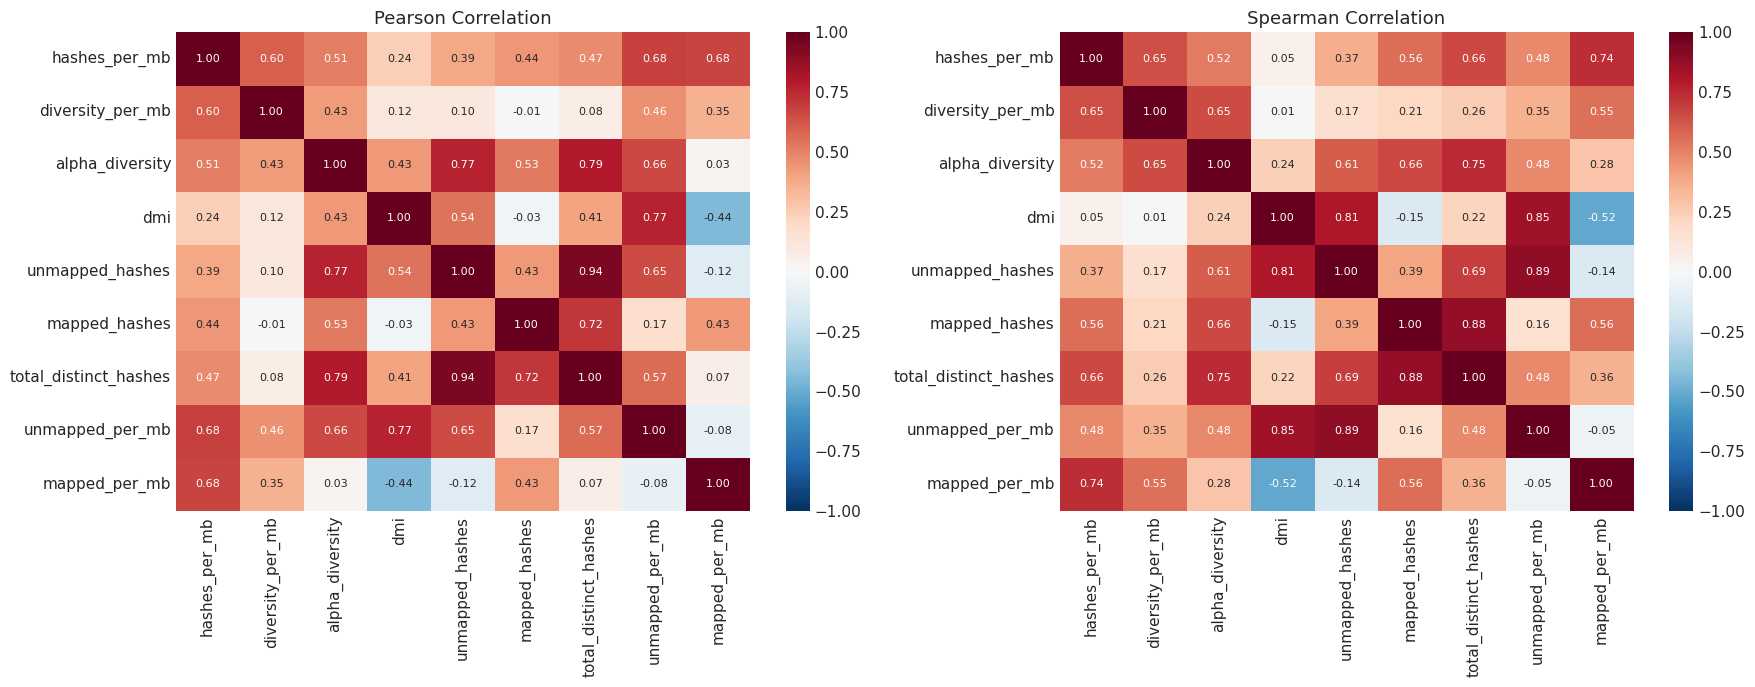

Figure saved: correlation_matrices.png


In [62]:
# Visualize correlation matrix
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Pearson
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, 
            vmin=-1, vmax=1, ax=axes[0], fmt='.2f', annot_kws={'size': 8})
axes[0].set_title('Pearson Correlation')

# Spearman
sns.heatmap(corr_matrix_spearman, annot=True, cmap='RdBu_r', center=0,
            vmin=-1, vmax=1, ax=axes[1], fmt='.2f', annot_kws={'size': 8})
axes[1].set_title('Spearman Correlation')

plt.tight_layout()
plt.savefig('correlation_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved: correlation_matrices.png")

In [63]:
# Key correlation: DMI vs hashes_per_mb and diversity_per_mb
print("\nKey Correlations with DMI:")
print("=" * 60)

for var in ['hashes_per_mb', 'diversity_per_mb', 'alpha_diversity', 'unmapped_per_mb']:
    if var in df_dmi.columns:
        r_pearson, p_pearson = pearsonr(df_dmi['dmi'], df_dmi[var])
        r_spearman, p_spearman = spearmanr(df_dmi['dmi'], df_dmi[var])
        tau, p_tau = kendalltau(df_dmi['dmi'], df_dmi[var])
        
        print(f"\nDMI vs {var}:")
        print(f"  Pearson r  = {r_pearson:.4f} (p = {p_pearson:.2e})")
        print(f"  Spearman ρ = {r_spearman:.4f} (p = {p_spearman:.2e})")
        print(f"  Kendall τ  = {tau:.4f} (p = {p_tau:.2e})")


Key Correlations with DMI:

DMI vs hashes_per_mb:
  Pearson r  = 0.2445 (p = 0.00e+00)
  Spearman ρ = 0.0541 (p = 3.38e-125)
  Kendall τ  = 0.0126 (p = 8.99e-17)

DMI vs diversity_per_mb:
  Pearson r  = 0.1161 (p = 0.00e+00)
  Spearman ρ = 0.0059 (p = 9.06e-03)
  Kendall τ  = -0.0129 (p = 2.16e-17)

DMI vs alpha_diversity:
  Pearson r  = 0.4307 (p = 0.00e+00)
  Spearman ρ = 0.2367 (p = 0.00e+00)
  Kendall τ  = 0.1628 (p = 0.00e+00)

DMI vs unmapped_per_mb:
  Pearson r  = 0.7699 (p = 0.00e+00)
  Spearman ρ = 0.8469 (p = 0.00e+00)
  Kendall τ  = 0.6646 (p = 0.00e+00)


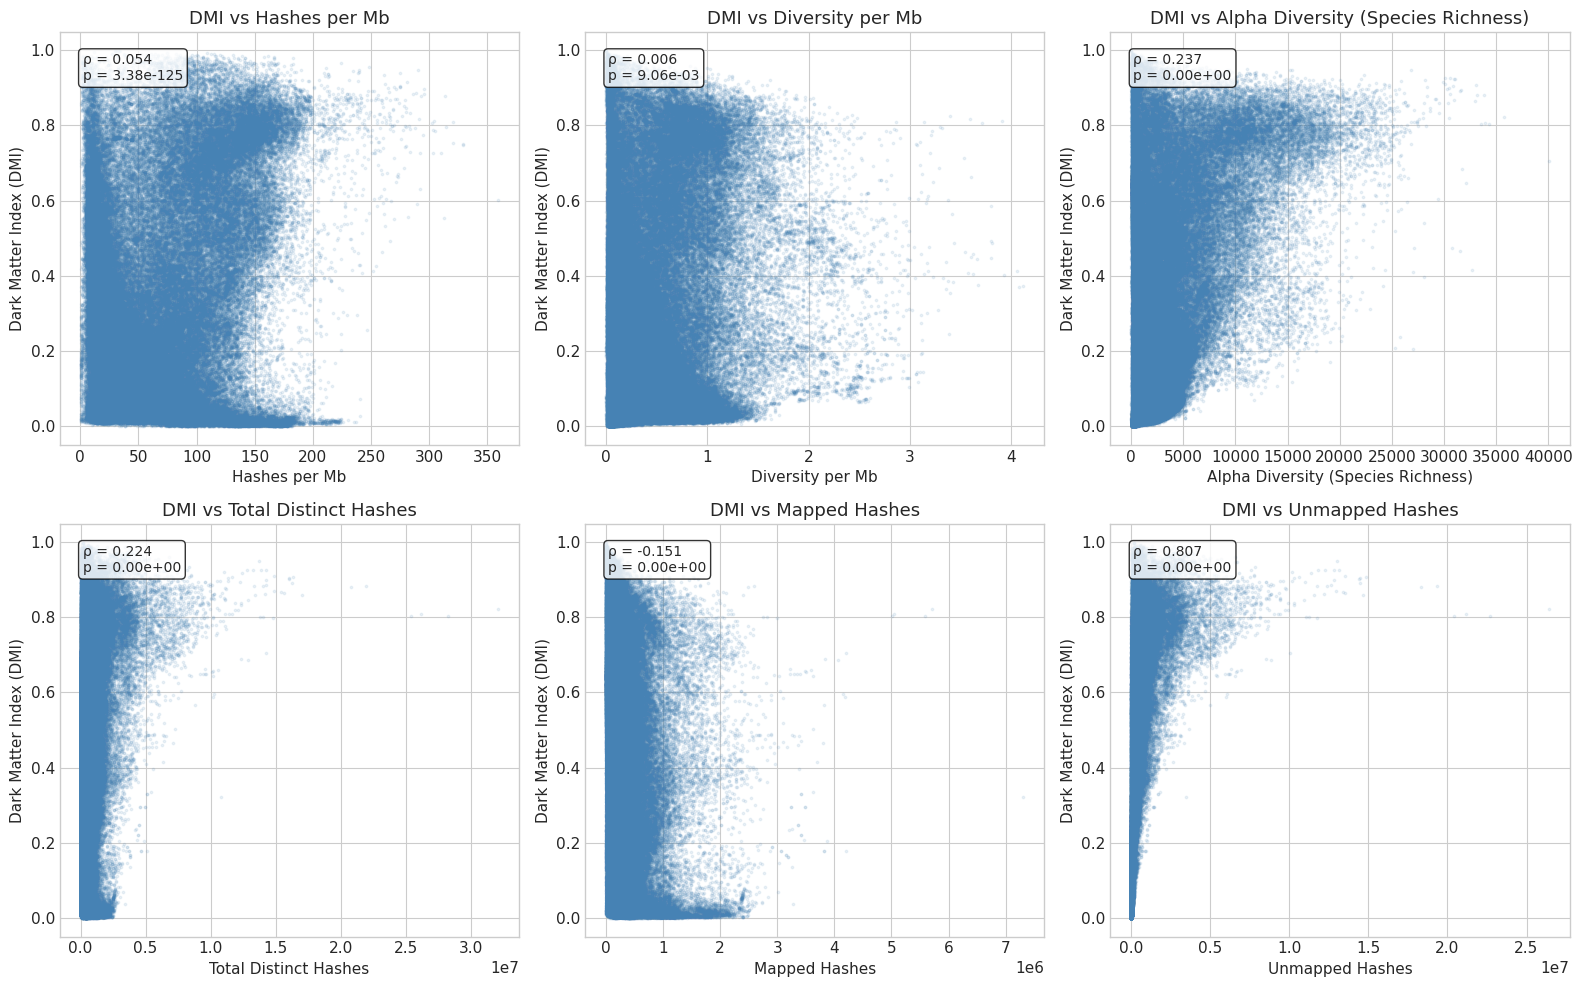

Figure saved: dmi_vs_metrics_scatter.png


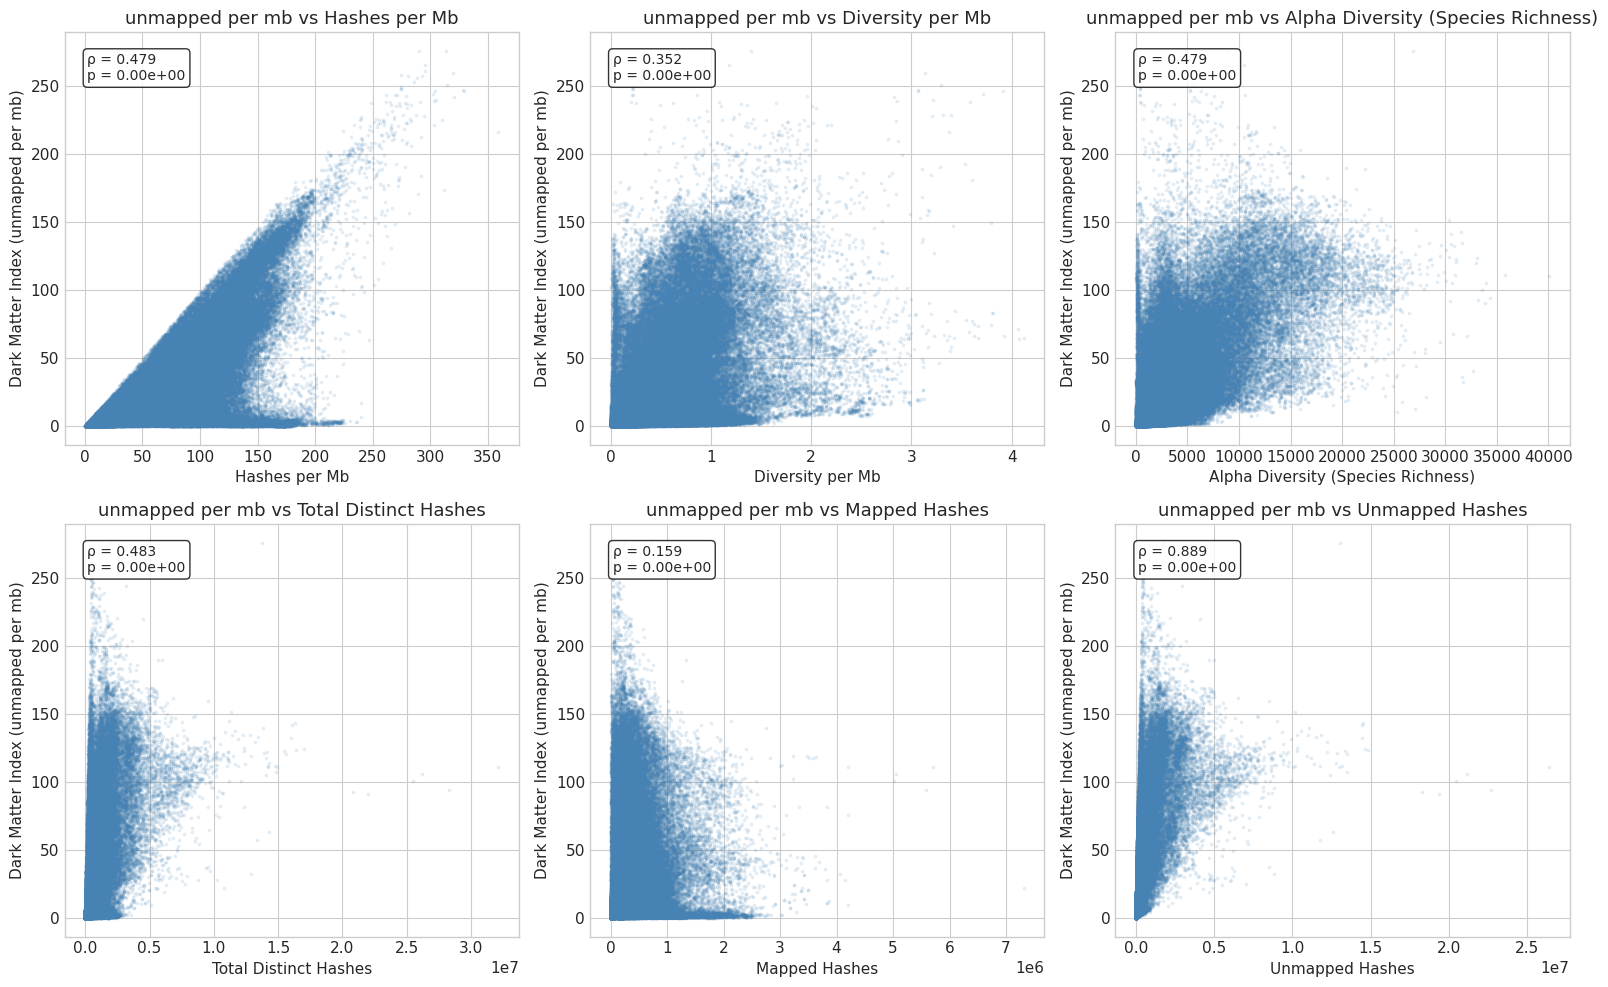

Figure saved: dmi_vs_metrics_scatter.png


In [64]:
# Scatter plots: DMI vs key metrics
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

plot_configs = [
    ('hashes_per_mb', 'Hashes per Mb'),
    ('diversity_per_mb', 'Diversity per Mb'),
    ('alpha_diversity', 'Alpha Diversity (Species Richness)'),
    ('total_distinct_hashes', 'Total Distinct Hashes'),
    ('mapped_hashes', 'Mapped Hashes'),
    ('unmapped_hashes', 'Unmapped Hashes')
]

for idx, (var, title) in enumerate(plot_configs):
    if var not in df_dmi.columns:
        continue
    ax = axes[idx // 3, idx % 3]
    
    ax.scatter(df_dmi[var], df_dmi['dmi'], alpha=0.1, s=3, color='steelblue')
    
    # Add correlation info
    r, p = spearmanr(df_dmi[var], df_dmi['dmi'])
    ax.text(0.05, 0.95, f'ρ = {r:.3f}\np = {p:.2e}', 
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_xlabel(title)
    ax.set_ylabel('Dark Matter Index (DMI)')
    ax.set_title(f'DMI vs {title}')

plt.tight_layout()
plt.savefig('dmi_vs_metrics_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved: dmi_vs_metrics_scatter.png")

# same but with unmapped_per_mb
# Scatter plots: unmapped_per_mb vs key metrics
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

plot_configs = [
    ('hashes_per_mb', 'Hashes per Mb'),
    ('diversity_per_mb', 'Diversity per Mb'),
    ('alpha_diversity', 'Alpha Diversity (Species Richness)'),
    ('total_distinct_hashes', 'Total Distinct Hashes'),
    ('mapped_hashes', 'Mapped Hashes'),
    ('unmapped_hashes', 'Unmapped Hashes')
]

for idx, (var, title) in enumerate(plot_configs):
    if var not in df_dmi.columns:
        continue
    ax = axes[idx // 3, idx % 3]
    
    ax.scatter(df_dmi[var], df_dmi['unmapped_per_mb'], alpha=0.1, s=3, color='steelblue')
    
    # Add correlation info
    r, p = spearmanr(df_dmi[var], df_dmi['unmapped_per_mb'])
    ax.text(0.05, 0.95, f'ρ = {r:.3f}\np = {p:.2e}', 
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_xlabel(title)
    ax.set_ylabel('Dark Matter Index (unmapped per mb)')
    ax.set_title(f'unmapped per mb vs {title}')

plt.tight_layout()
plt.savefig('unmapped_per_mb_vs_metrics_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved: dmi_vs_metrics_scatter.png")

### Interpretation Guide

**Key relationships to look for:**

1. **DMI vs Hashes per Mb**: 
   - Positive correlation suggests samples with more hashes have more dark matter
   - Could indicate that high-hash samples are sampling deeper into unexplored sequence space

2. **DMI vs Diversity per Mb**:
   - Negative correlation would support hypothesis: high DMI → low diversity ratio
   - Positive would be surprising and require reinterpretation

3. **DMI vs Alpha Diversity**:
   - Should be weakly negative or uncorrelated if DMI represents truly unmapped content
   - Strong negative correlation would strongly support the hypothesis

## 4. Hash-Diversity Plots with DMI Coloring

Recreating the original organism-stratified scatter plots, but now colored by DMI to visualize whether the "outlier" clusters have elevated dark matter content.

In [65]:
# Get top organisms by sample count
if 'organism' in df_dmi.columns:
    organism_counts = df_dmi['organism'].value_counts()
    print("Top 20 organisms by sample count:")
    print("=" * 50)
    for i, (org, count) in enumerate(organism_counts.head(20).items()):
        median_dmi = df_dmi[df_dmi['organism'] == org]['dmi'].median()
        print(f"{i+1:2}. {org:40} n={count:6,}  median DMI={median_dmi:.3f}")

Top 20 organisms by sample count:
 1. human gut metagenome                     n=57,354  median DMI=0.071
 2. metagenome                               n=17,986  median DMI=0.196
 3. gut metagenome                           n=14,668  median DMI=0.100
 4. soil metagenome                          n= 8,607  median DMI=0.762
 5. feces metagenome                         n= 6,449  median DMI=0.112
 6. human metagenome                         n= 6,406  median DMI=0.061
 7. marine metagenome                        n= 6,361  median DMI=0.536
 8. mouse gut metagenome                     n= 5,107  median DMI=0.063
 9. Homo sapiens                             n= 5,107  median DMI=0.096
10. human feces metagenome                   n= 4,638  median DMI=0.231
11. unidentified                             n= 3,763  median DMI=0.221
12. wastewater metagenome                    n= 2,802  median DMI=0.306
13. pig gut metagenome                       n= 2,739  median DMI=0.214
14. sediment metagenome       

In [66]:
def plot_organism_hash_diversity_dmi(df, organism, ax):
    """
    Plot hash density vs diversity for a single organism, colored by DMI.
    """
    subset = df[df['organism'] == organism].copy()
    
    if len(subset) == 0:
        ax.text(0.5, 0.5, f'No data for {organism}', ha='center', va='center', transform=ax.transAxes)
        return
    
    # Create scatter plot colored by DMI
    scatter = ax.scatter(subset['hashes_per_mb'], subset['diversity_per_mb'], 
                        c=subset['dmi'], cmap='RdYlBu_r', 
                        alpha=0.6, s=10, vmin=0, vmax=1)
    
    # Add regression line
    x = subset['hashes_per_mb'].values
    y = subset['diversity_per_mb'].values
    
    # Remove NaN values for regression
    mask = ~(np.isnan(x) | np.isnan(y))
    x_clean, y_clean = x[mask], y[mask]
    
    if len(x_clean) > 2:
        slope, intercept, r_value, p_value, std_err = stats.linregress(x_clean, y_clean)
        x_line = np.linspace(x_clean.min(), x_clean.max(), 100)
        y_line = slope * x_line + intercept
        ax.plot(x_line, y_line, 'r-', linewidth=2, alpha=0.8)
        
        # Calculate additional correlations
        r_spearman, _ = spearmanr(x_clean, y_clean)
        
        # Add stats text
        stats_text = f'n={len(subset):,}\nr={r_value:.3f}\nρ={r_spearman:.3f}\nR²={r_value**2:.3f}'
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=8,
                verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_xlabel('Hashes per Mb')
    ax.set_ylabel('Diversity per Mb')
    ax.set_title(organism)
    
    return scatter

Plotting 15 organisms


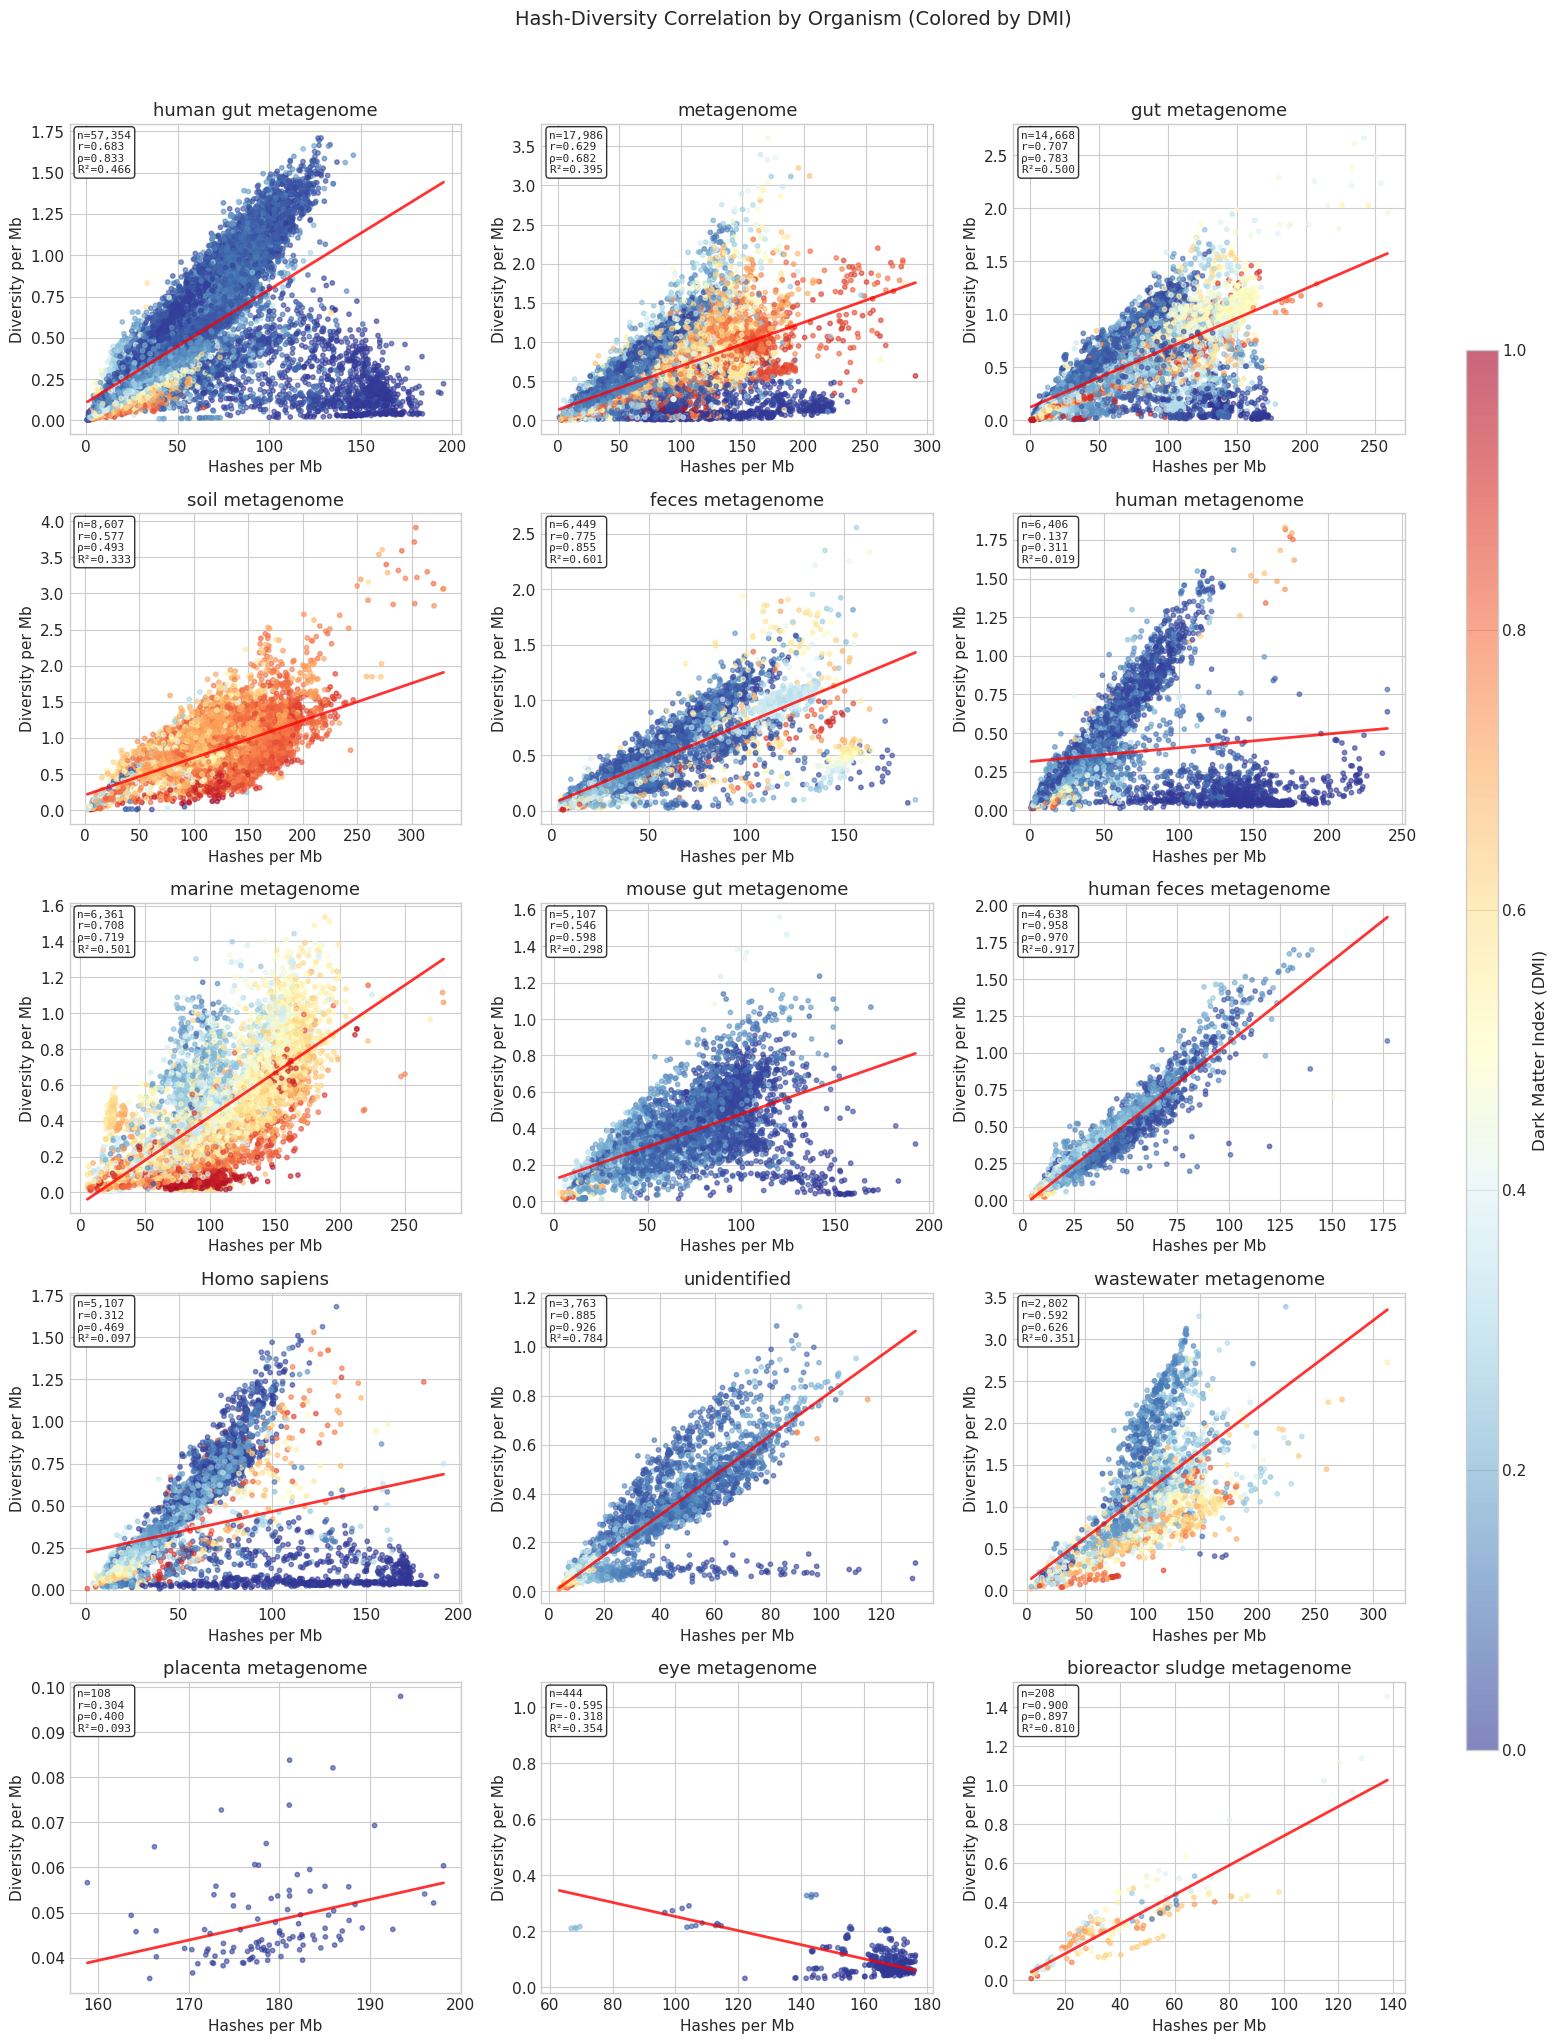


Figure saved: hash_diversity_by_organism_dmi_colored.png


In [67]:
# Select organisms for the multi-panel plot
# Using the same organisms from the original figure
target_organisms = [
    'human gut metagenome', 'metagenome', 'gut metagenome',
    'soil metagenome', 'feces metagenome', 'human metagenome',
    'marine metagenome', 'mouse gut metagenome', 'human feces metagenome',
    'Homo sapiens', 'unidentified', 'wastewater metagenome', 'placenta metagenome', 'eye metagenome', 'bioreactor sludge metagenome'
]

# Filter to organisms that exist in data
available_organisms = [org for org in target_organisms if org in df_dmi['organism'].values]
print(f"Plotting {len(available_organisms)} organisms")

# Create multi-panel figure
n_cols = 3
n_rows = (len(available_organisms) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
axes = axes.flatten()

scatter = None
for idx, organism in enumerate(available_organisms):
    scatter = plot_organism_hash_diversity_dmi(df_dmi, organism, axes[idx])

# Hide unused axes
for idx in range(len(available_organisms), len(axes)):
    axes[idx].set_visible(False)

# Add colorbar
if scatter is not None:
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(scatter, cax=cbar_ax)
    cbar.set_label('Dark Matter Index (DMI)', fontsize=12)

plt.suptitle('Hash-Diversity Correlation by Organism (Colored by DMI)', fontsize=14, y=1.02)
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig('hash_diversity_by_organism_dmi_colored.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved: hash_diversity_by_organism_dmi_colored.png")

### Interpretation Guide

**Color interpretation:**
- **Blue**: Low DMI (well-characterized samples, most hashes map to reference databases)
- **Yellow**: Medium DMI
- **Red**: High DMI (high dark matter content, many unmapped hashes)

**What to look for:**
1. Do the outlier clusters (bottom-right regions in some panels) appear red/yellow?
   - If yes: DMI explains the anomalous hash-diversity relationship
   - If no: Other factors drive the multimodality

2. Is there a gradient along the regression line?
   - Points above the line might have lower DMI (more characterized content)
   - Points below the line might have higher DMI (dark matter inflating hash counts)

## 5. Detailed Organism Analysis: Top and Bottom DMI

Deep dive into organisms with highest and lowest median DMI values.

In [68]:
# Calculate organism-level DMI statistics
organism_stats = df_dmi.groupby('organism').agg(
    count=('dmi', 'count'),
    median_dmi=('dmi', 'median'),
    mean_dmi=('dmi', 'mean'),
    std_dmi=('dmi', 'std'),
    q25_dmi=('dmi', lambda x: x.quantile(0.25)),
    q75_dmi=('dmi', lambda x: x.quantile(0.75)),
    median_hashes_per_mb=('hashes_per_mb', 'median'),
    median_diversity_per_mb=('diversity_per_mb', 'median'),
    median_alpha_diversity=('alpha_diversity', 'median')
).reset_index()

# Filter to organisms with at least 100 samples
organism_stats_filtered = organism_stats[organism_stats['count'] >= 100].copy()
print(f"Organisms with >= 100 samples: {len(organism_stats_filtered)}")

Organisms with >= 100 samples: 111


In [69]:
# Top 10 by median DMI
top10_dmi = organism_stats_filtered.nlargest(10, 'median_dmi')

print("\n" + "=" * 100)
print("TOP 10 ORGANISMS BY MEDIAN DMI (n >= 100)")
print("=" * 100)
print("\nThese organisms have the highest proportion of 'dark matter' — unmapped k-mer content.")
print("High DMI may indicate: (1) underrepresented in reference databases, (2) novel diversity,")
print("(3) environmental niches not well-characterized, or (4) technical artifacts.\n")

for i, row in top10_dmi.iterrows():
    print(f"\n{row['organism']}")
    print(f"  Sample count: {int(row['count']):,}")
    print(f"  DMI: median={row['median_dmi']:.4f}, mean={row['mean_dmi']:.4f}, std={row['std_dmi']:.4f}")
    print(f"  IQR: [{row['q25_dmi']:.4f}, {row['q75_dmi']:.4f}]")
    print(f"  Hashes/Mb: {row['median_hashes_per_mb']:.2f}")
    print(f"  Diversity/Mb: {row['median_diversity_per_mb']:.4f}")
    print(f"  Alpha diversity: {row['median_alpha_diversity']:.0f}")


TOP 10 ORGANISMS BY MEDIAN DMI (n >= 100)

These organisms have the highest proportion of 'dark matter' — unmapped k-mer content.
High DMI may indicate: (1) underrepresented in reference databases, (2) novel diversity,
(3) environmental niches not well-characterized, or (4) technical artifacts.


termite gut metagenome
  Sample count: 123
  DMI: median=0.9164, mean=0.8747, std=0.1129
  IQR: [0.8675, 0.9393]
  Hashes/Mb: 83.70
  Diversity/Mb: 0.1685
  Alpha diversity: 2412

museum specimen metagenome
  Sample count: 147
  DMI: median=0.8186, mean=0.7950, std=0.1031
  IQR: [0.7320, 0.8786]
  Hashes/Mb: 71.15
  Diversity/Mb: 0.4780
  Alpha diversity: 6124

wetland metagenome
  Sample count: 272
  DMI: median=0.8124, mean=0.7460, std=0.1619
  IQR: [0.6454, 0.8676]
  Hashes/Mb: 124.29
  Diversity/Mb: 0.5260
  Alpha diversity: 8780

human blood metagenome
  Sample count: 127
  DMI: median=0.8015, mean=0.7847, std=0.0764
  IQR: [0.7746, 0.8185]
  Hashes/Mb: 28.22
  Diversity/Mb: 0.0860
  Alp

In [70]:
# Bottom 10 by median DMI
bottom10_dmi = organism_stats_filtered.nsmallest(10, 'median_dmi')

print("\n" + "=" * 100)
print("BOTTOM 10 ORGANISMS BY MEDIAN DMI (n >= 100)")
print("=" * 100)
print("\nThese organisms have the lowest proportion of 'dark matter' — most k-mers map to references.")
print("Low DMI indicates: (1) well-characterized organisms, (2) extensively sequenced,")
print("(3) lab strains or model organisms, or (4) limited natural diversity.\n")

for i, row in bottom10_dmi.iterrows():
    print(f"\n{row['organism']}")
    print(f"  Sample count: {int(row['count']):,}")
    print(f"  DMI: median={row['median_dmi']:.4f}, mean={row['mean_dmi']:.4f}, std={row['std_dmi']:.4f}")
    print(f"  IQR: [{row['q25_dmi']:.4f}, {row['q75_dmi']:.4f}]")
    print(f"  Hashes/Mb: {row['median_hashes_per_mb']:.2f}")
    print(f"  Diversity/Mb: {row['median_diversity_per_mb']:.4f}")
    print(f"  Alpha diversity: {row['median_alpha_diversity']:.0f}")


BOTTOM 10 ORGANISMS BY MEDIAN DMI (n >= 100)

These organisms have the lowest proportion of 'dark matter' — most k-mers map to references.
Low DMI indicates: (1) well-characterized organisms, (2) extensively sequenced,
(3) lab strains or model organisms, or (4) limited natural diversity.


eye metagenome
  Sample count: 444
  DMI: median=0.0062, mean=0.0152, std=0.0394
  IQR: [0.0024, 0.0142]
  Hashes/Mb: 168.16
  Diversity/Mb: 0.0701
  Alpha diversity: 391

metagenomes
  Sample count: 127
  DMI: median=0.0127, mean=0.0909, std=0.2187
  IQR: [0.0098, 0.0218]
  Hashes/Mb: 171.61
  Diversity/Mb: 0.2028
  Alpha diversity: 679

Oryza sativa Japonica Group
  Sample count: 142
  DMI: median=0.0155, mean=0.0164, std=0.0055
  IQR: [0.0130, 0.0184]
  Hashes/Mb: 96.98
  Diversity/Mb: 0.0848
  Alpha diversity: 240

human sputum metagenome
  Sample count: 191
  DMI: median=0.0178, mean=0.1120, std=0.1625
  IQR: [0.0040, 0.1798]
  Hashes/Mb: 142.89
  Diversity/Mb: 0.0670
  Alpha diversity: 500

hu

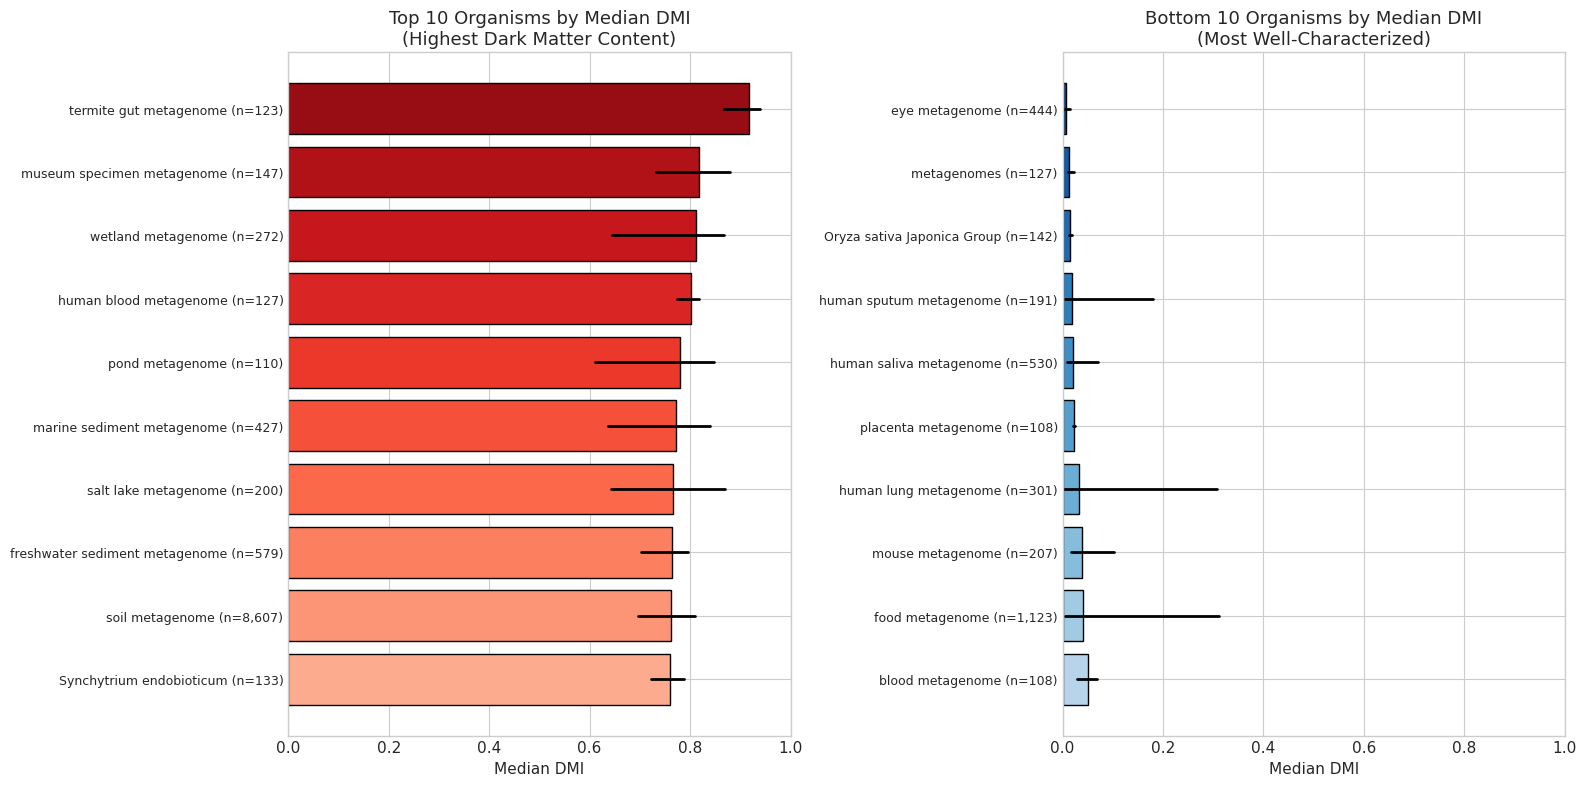


Figure saved: top_bottom_organisms_dmi.png


In [71]:
# Visualization: Top and Bottom organisms
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Top 10
ax = axes[0]
top10_sorted = top10_dmi.sort_values('median_dmi', ascending=True)
colors_top = plt.cm.Reds(np.linspace(0.3, 0.9, len(top10_sorted)))
bars = ax.barh(range(len(top10_sorted)), top10_sorted['median_dmi'], 
               color=colors_top, edgecolor='black')

# Add error bars for IQR
for idx, (_, row) in enumerate(top10_sorted.iterrows()):
    ax.plot([row['q25_dmi'], row['q75_dmi']], [idx, idx], 'k-', linewidth=2)
    
ax.set_yticks(range(len(top10_sorted)))
ax.set_yticklabels([f"{row['organism']} (n={int(row['count']):,})" 
                    for _, row in top10_sorted.iterrows()], fontsize=9)
ax.set_xlabel('Median DMI')
ax.set_title('Top 10 Organisms by Median DMI\n(Highest Dark Matter Content)')
ax.set_xlim(0, 1)

# Bottom 10
ax = axes[1]
bottom10_sorted = bottom10_dmi.sort_values('median_dmi', ascending=False)
colors_bottom = plt.cm.Blues(np.linspace(0.3, 0.9, len(bottom10_sorted)))
bars = ax.barh(range(len(bottom10_sorted)), bottom10_sorted['median_dmi'],
               color=colors_bottom, edgecolor='black')

# Add error bars for IQR
for idx, (_, row) in enumerate(bottom10_sorted.iterrows()):
    ax.plot([row['q25_dmi'], row['q75_dmi']], [idx, idx], 'k-', linewidth=2)

ax.set_yticks(range(len(bottom10_sorted)))
ax.set_yticklabels([f"{row['organism']} (n={int(row['count']):,})" 
                    for _, row in bottom10_sorted.iterrows()], fontsize=9)
ax.set_xlabel('Median DMI')
ax.set_title('Bottom 10 Organisms by Median DMI\n(Most Well-Characterized)')
ax.set_xlim(0, 1)

plt.tight_layout()
plt.savefig('top_bottom_organisms_dmi.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved: top_bottom_organisms_dmi.png")

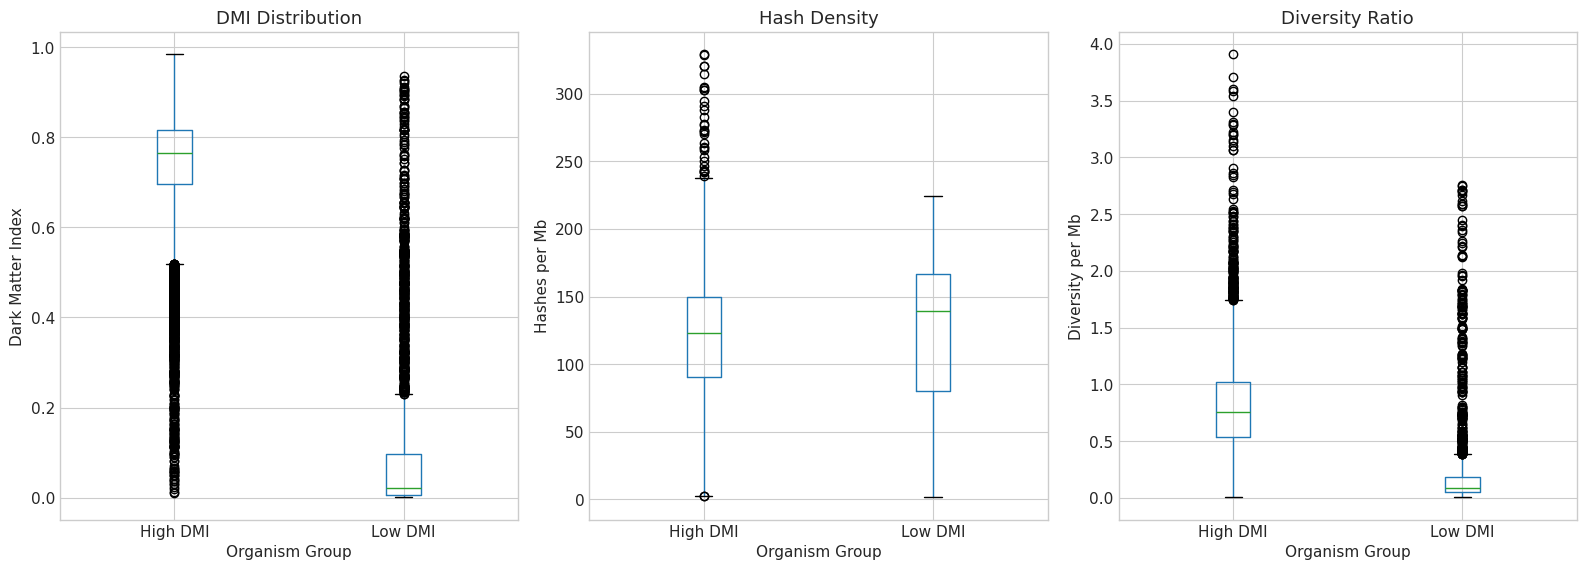

Figure saved: high_low_dmi_comparison.png


In [72]:
# Boxplot comparison: Top 10 vs Bottom 10 organisms
top10_names = top10_dmi['organism'].tolist()
bottom10_names = bottom10_dmi['organism'].tolist()

df_comparison = df_dmi[df_dmi['organism'].isin(top10_names + bottom10_names)].copy()
df_comparison['group'] = df_comparison['organism'].apply(
    lambda x: 'High DMI' if x in top10_names else 'Low DMI'
)

fig, axes = plt.subplots(1, 3, figsize=(16, 6))

# DMI distribution
ax = axes[0]
df_comparison.boxplot(column='dmi', by='group', ax=ax)
ax.set_xlabel('Organism Group')
ax.set_ylabel('Dark Matter Index')
ax.set_title('DMI Distribution')
plt.suptitle('')

# Hashes per Mb
ax = axes[1]
df_comparison.boxplot(column='hashes_per_mb', by='group', ax=ax)
ax.set_xlabel('Organism Group')
ax.set_ylabel('Hashes per Mb')
ax.set_title('Hash Density')
plt.suptitle('')

# Diversity per Mb
ax = axes[2]
df_comparison.boxplot(column='diversity_per_mb', by='group', ax=ax)
ax.set_xlabel('Organism Group')
ax.set_ylabel('Diversity per Mb')
ax.set_title('Diversity Ratio')
plt.suptitle('')

plt.tight_layout()
plt.savefig('high_low_dmi_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved: high_low_dmi_comparison.png")

## 6. Outlier Investigation: Testing the Hypothesis Directly

Identifying samples that deviate from the expected hash-diversity relationship and testing if they have elevated DMI.

In [73]:
def identify_outliers(df, x_col, y_col, residual_threshold=2):
    """
    Identify outliers based on residuals from linear regression.
    
    Outliers are defined as points whose residual (observed - predicted)
    is more than `residual_threshold` standard deviations below the mean.
    
    These are samples with lower diversity than expected given their hash density.
    """
    # Clean data
    mask = df[x_col].notna() & df[y_col].notna()
    df_clean = df[mask].copy()
    
    x = df_clean[x_col].values
    y = df_clean[y_col].values
    
    # Fit linear regression
    slope, intercept, _, _, _ = stats.linregress(x, y)
    
    # Calculate residuals
    y_pred = slope * x + intercept
    residuals = y - y_pred
    
    # Standardize residuals
    residual_mean = residuals.mean()
    residual_std = residuals.std()
    standardized_residuals = (residuals - residual_mean) / residual_std
    
    # Identify negative outliers (below regression line)
    df_clean['residual'] = residuals
    df_clean['std_residual'] = standardized_residuals
    df_clean['is_outlier'] = standardized_residuals < -residual_threshold
    
    return df_clean

In [74]:
# Identify outliers for each major organism
print("Outlier Analysis: Samples with LOW diversity relative to hash density")
print("="*80)
print("\nHypothesis: Outliers (below regression line) should have HIGHER DMI")
print("")

outlier_results = []

for organism in available_organisms:
    subset = df_dmi[df_dmi['organism'] == organism]
    if len(subset) < 100:
        continue
    
    df_with_outliers = identify_outliers(subset, 'hashes_per_mb', 'diversity_per_mb', residual_threshold=1.5)
    
    n_outliers = df_with_outliers['is_outlier'].sum()
    n_total = len(df_with_outliers)
    
    dmi_outliers = df_with_outliers[df_with_outliers['is_outlier']]['dmi']
    dmi_normal = df_with_outliers[~df_with_outliers['is_outlier']]['dmi']
    
    # Statistical test
    if len(dmi_outliers) > 5 and len(dmi_normal) > 5:
        stat, pvalue = stats.mannwhitneyu(dmi_outliers, dmi_normal, alternative='greater')
        
        result = {
            'organism': organism,
            'n_total': n_total,
            'n_outliers': n_outliers,
            'pct_outliers': 100 * n_outliers / n_total,
            'dmi_outliers_median': dmi_outliers.median(),
            'dmi_normal_median': dmi_normal.median(),
            'dmi_difference': dmi_outliers.median() - dmi_normal.median(),
            'mannwhitney_pvalue': pvalue,
            'significant': pvalue < 0.05
        }
        outlier_results.append(result)

outlier_df = pd.DataFrame(outlier_results)
outlier_df = outlier_df.sort_values('dmi_difference', ascending=False)

Outlier Analysis: Samples with LOW diversity relative to hash density

Hypothesis: Outliers (below regression line) should have HIGHER DMI



In [75]:
# Display outlier analysis results
print("\nResults: Do outliers have higher DMI than normal samples?")
print("-" * 100)
print(f"{'Organism':<30} {'n_out':>6} {'%out':>6} {'DMI_out':>8} {'DMI_norm':>8} {'Δ DMI':>8} {'p-value':>10} {'Sig?':>5}")
print("-" * 100)

for _, row in outlier_df.iterrows():
    sig_marker = '***' if row['mannwhitney_pvalue'] < 0.001 else ('**' if row['mannwhitney_pvalue'] < 0.01 else ('*' if row['mannwhitney_pvalue'] < 0.05 else ''))
    print(f"{row['organism']:<30} {row['n_outliers']:>6} {row['pct_outliers']:>5.1f}% {row['dmi_outliers_median']:>8.4f} {row['dmi_normal_median']:>8.4f} {row['dmi_difference']:>+8.4f} {row['mannwhitney_pvalue']:>10.2e} {sig_marker:>5}")


Results: Do outliers have higher DMI than normal samples?
----------------------------------------------------------------------------------------------------
Organism                        n_out   %out  DMI_out DMI_norm    Δ DMI    p-value  Sig?
----------------------------------------------------------------------------------------------------
marine metagenome                 321   5.0%   0.8482   0.5234  +0.3248  9.29e-114   ***
wastewater metagenome             110   3.9%   0.5437   0.3011  +0.2426   5.85e-18   ***
feces metagenome                  296   4.6%   0.3081   0.1098  +0.1982   6.99e-16   ***
bioreactor sludge metagenome       16   7.7%   0.6335   0.5019  +0.1316   1.80e-03    **
soil metagenome                   434   5.0%   0.8043   0.7604  +0.0439   5.65e-33   ***
eye metagenome                     15   3.4%   0.0092   0.0057  +0.0035   1.02e-03    **
mouse gut metagenome              204   4.0%   0.0207   0.0651  -0.0444   1.00e+00      
gut metagenome             

In [76]:
# Summary statistics
n_significant = outlier_df['significant'].sum()
n_positive_diff = (outlier_df['dmi_difference'] > 0).sum()

print(f"\n\nSUMMARY:")
print(f"  Organisms analyzed: {len(outlier_df)}")
print(f"  Organisms where outliers have HIGHER DMI: {n_positive_diff} ({100*n_positive_diff/len(outlier_df):.1f}%)")
print(f"  Statistically significant (p < 0.05): {n_significant} ({100*n_significant/len(outlier_df):.1f}%)")

if n_positive_diff / len(outlier_df) > 0.5:
    print("\n  → SUPPORTS HYPOTHESIS: Outliers tend to have higher DMI")
else:
    print("\n  → DOES NOT SUPPORT HYPOTHESIS: Outliers don't consistently have higher DMI")



SUMMARY:
  Organisms analyzed: 14
  Organisms where outliers have HIGHER DMI: 6 (42.9%)
  Statistically significant (p < 0.05): 6 (42.9%)

  → DOES NOT SUPPORT HYPOTHESIS: Outliers don't consistently have higher DMI


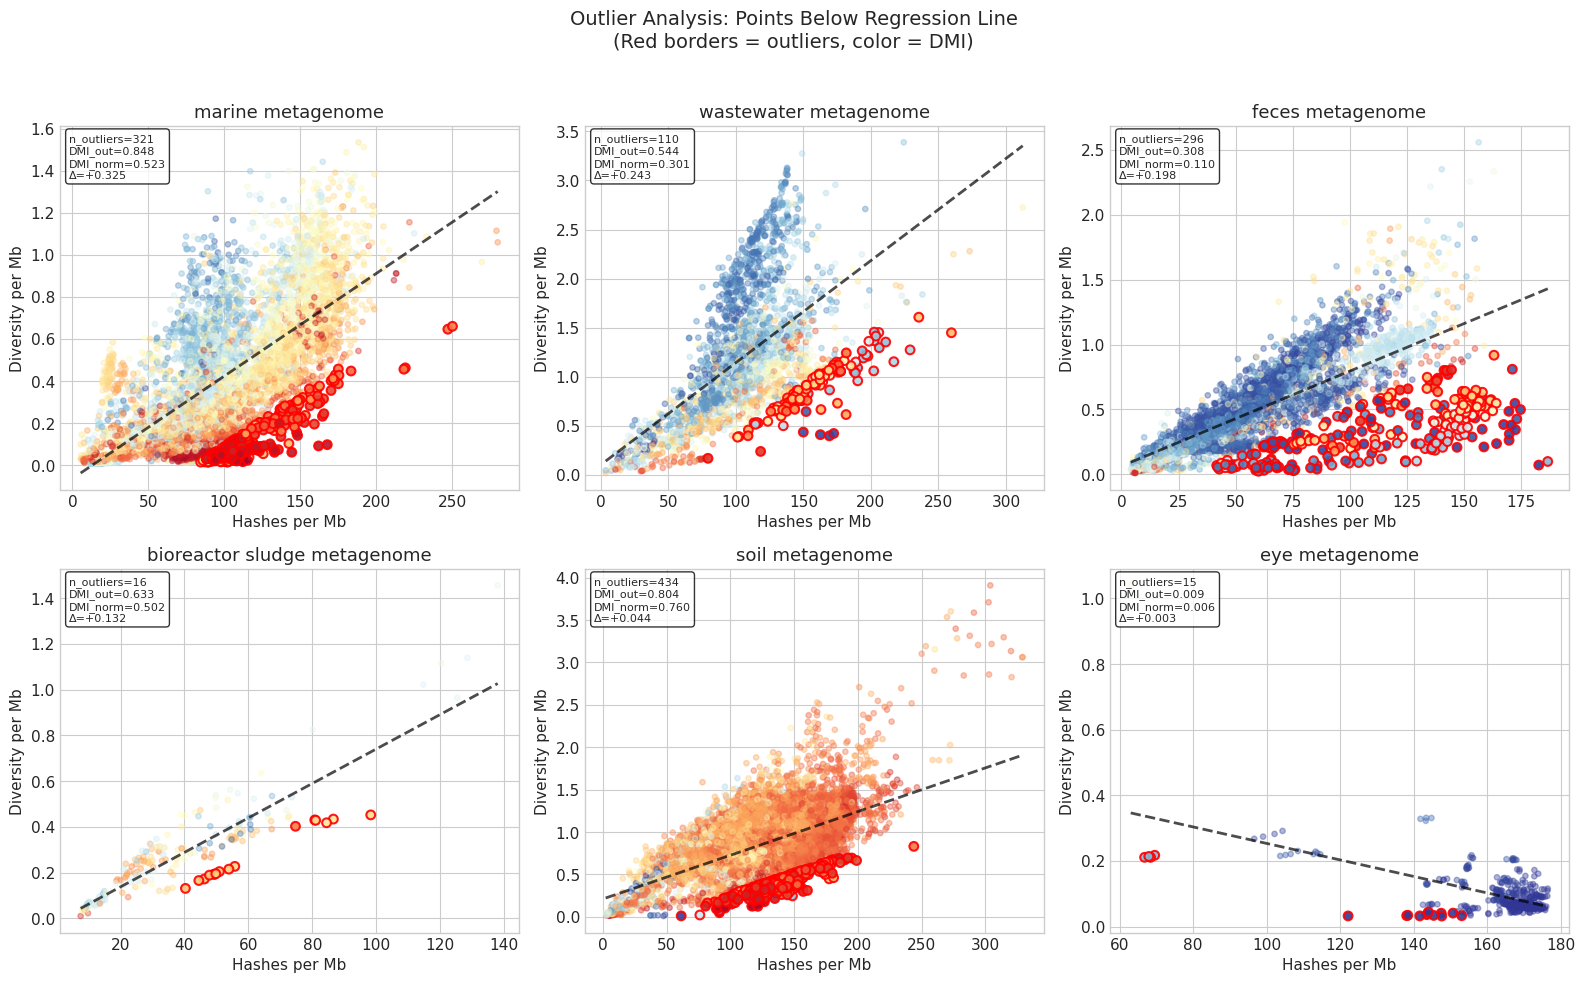


Figure saved: outlier_dmi_analysis.png


In [77]:
# Visualize outliers vs normal for selected organisms
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

# Select organisms with significant differences
top_organisms = outlier_df.nlargest(6, 'dmi_difference')['organism'].tolist()

for idx, organism in enumerate(top_organisms):
    if idx >= 6:
        break
        
    ax = axes[idx]
    subset = df_dmi[df_dmi['organism'] == organism]
    df_with_outliers = identify_outliers(subset, 'hashes_per_mb', 'diversity_per_mb', residual_threshold=1.5)
    
    # Plot normal points
    normal = df_with_outliers[~df_with_outliers['is_outlier']]
    outliers = df_with_outliers[df_with_outliers['is_outlier']]
    
    ax.scatter(normal['hashes_per_mb'], normal['diversity_per_mb'], 
               c=normal['dmi'], cmap='RdYlBu_r', alpha=0.4, s=15, vmin=0, vmax=1, label='Normal')
    ax.scatter(outliers['hashes_per_mb'], outliers['diversity_per_mb'],
               c=outliers['dmi'], cmap='RdYlBu_r', alpha=0.9, s=40, vmin=0, vmax=1, 
               edgecolor='red', linewidth=1.5, label='Outliers')
    
    # Add regression line
    x = df_with_outliers['hashes_per_mb'].values
    y = df_with_outliers['diversity_per_mb'].values
    slope, intercept, _, _, _ = stats.linregress(x, y)
    x_line = np.linspace(x.min(), x.max(), 100)
    ax.plot(x_line, slope * x_line + intercept, 'k--', linewidth=2, alpha=0.7)
    
    # Stats
    row = outlier_df[outlier_df['organism'] == organism].iloc[0]
    ax.text(0.02, 0.98, 
            f"n_outliers={row['n_outliers']}\nDMI_out={row['dmi_outliers_median']:.3f}\nDMI_norm={row['dmi_normal_median']:.3f}\nΔ={row['dmi_difference']:+.3f}",
            transform=ax.transAxes, fontsize=8, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_xlabel('Hashes per Mb')
    ax.set_ylabel('Diversity per Mb')
    ax.set_title(organism)

plt.suptitle('Outlier Analysis: Points Below Regression Line\n(Red borders = outliers, color = DMI)', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('outlier_dmi_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved: outlier_dmi_analysis.png")

## 7. Additional Analyses

### 7.1 DMI by Platform and Sequencing Technology

Check if DMI varies by sequencing platform (potential technical artifact).

DMI by Sequencing Platform:
ILLUMINA             n= 192,893  median=0.1744  mean=0.2830


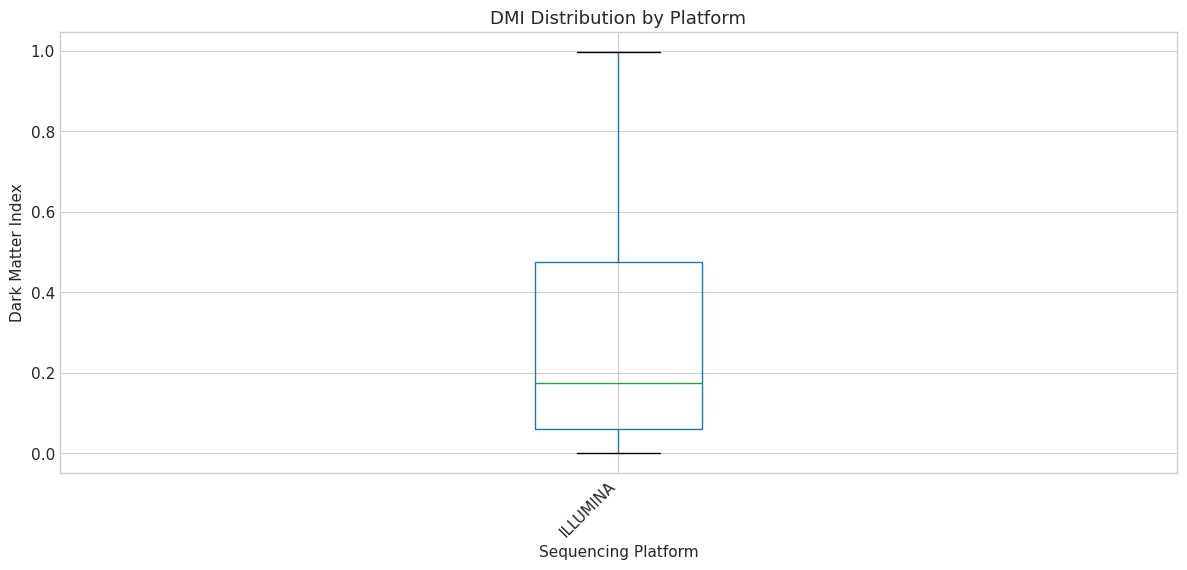


Figure saved: dmi_by_platform.png


In [78]:
if 'platform' in df_dmi.columns:
    platform_stats = df_dmi.groupby('platform').agg(
        count=('dmi', 'count'),
        median_dmi=('dmi', 'median'),
        mean_dmi=('dmi', 'mean'),
        std_dmi=('dmi', 'std')
    ).reset_index()
    platform_stats = platform_stats.sort_values('count', ascending=False)
    
    print("DMI by Sequencing Platform:")
    print("=" * 70)
    for _, row in platform_stats.iterrows():
        print(f"{row['platform']:20} n={int(row['count']):>8,}  median={row['median_dmi']:.4f}  mean={row['mean_dmi']:.4f}")
    
    # Box plot
    fig, ax = plt.subplots(figsize=(12, 6))
    platforms_to_plot = platform_stats[platform_stats['count'] >= 100]['platform'].tolist()
    df_platform = df_dmi[df_dmi['platform'].isin(platforms_to_plot)]
    df_platform.boxplot(column='dmi', by='platform', ax=ax)
    ax.set_xlabel('Sequencing Platform')
    ax.set_ylabel('Dark Matter Index')
    ax.set_title('DMI Distribution by Platform')
    plt.suptitle('')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('dmi_by_platform.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\nFigure saved: dmi_by_platform.png")
else:
    print("Platform column not available in dataset")

### 7.2 DMI by Biome

Environmental context and dark matter content.

DMI by Biome (n >= 100):
WWF_TEW_BIOME_11                         n=   764  median=0.6720  mean=0.6516
WWF_TEW_BIOME_99                         n=   280  median=0.6334  mean=0.5598
WWF_TEW_BIOME_14                         n=   208  median=0.5727  mean=0.5713
WWF_TEW_BIOME_02                         n=   461  median=0.3974  mean=0.4064
WWF_TEW_BIOME_06                         n= 6,958  median=0.2975  mean=0.3393
WWF_TEW_BIOME_13                         n= 6,024  median=0.2703  mean=0.3430
unknown                                  n=19,378  median=0.2691  mean=0.3365
WWF_TEW_BIOME_05                         n=12,213  median=0.2437  mean=0.3246
WWF_TEW_BIOME_10                         n=15,985  median=0.2379  mean=0.3467
WWF_TEW_BIOME_08                         n= 5,320  median=0.1943  mean=0.2907
WWF_TEW_BIOME_01                         n=12,456  median=0.1844  mean=0.3126
WWF_TEW_BIOME_07                         n= 4,916  median=0.1781  mean=0.2732
WWF_TEW_BIOME_12                       

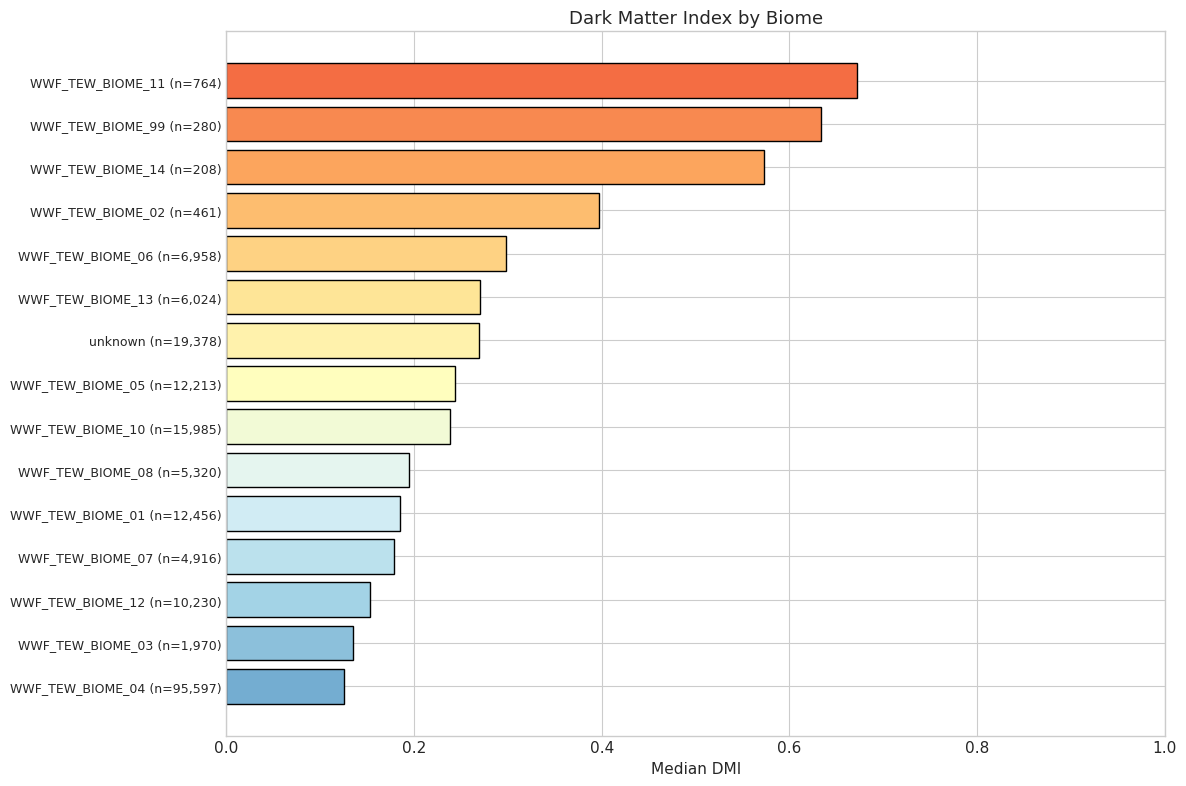


Figure saved: dmi_by_biome.png


In [79]:
if 'biome' in df_dmi.columns:
    biome_stats = df_dmi.groupby('biome').agg(
        count=('dmi', 'count'),
        median_dmi=('dmi', 'median'),
        mean_dmi=('dmi', 'mean'),
        std_dmi=('dmi', 'std')
    ).reset_index()
    
    biome_stats_filtered = biome_stats[biome_stats['count'] >= 100]
    biome_stats_filtered = biome_stats_filtered.sort_values('median_dmi', ascending=False)
    
    print("DMI by Biome (n >= 100):")
    print("=" * 80)
    for _, row in biome_stats_filtered.iterrows():
        print(f"{row['biome']:40} n={int(row['count']):>6,}  median={row['median_dmi']:.4f}  mean={row['mean_dmi']:.4f}")
    
    # Visualization
    if len(biome_stats_filtered) > 0:
        fig, ax = plt.subplots(figsize=(12, 8))
        biome_stats_filtered = biome_stats_filtered.sort_values('median_dmi', ascending=True)
        colors = plt.cm.RdYlBu_r(np.linspace(0.2, 0.8, len(biome_stats_filtered)))
        ax.barh(range(len(biome_stats_filtered)), biome_stats_filtered['median_dmi'],
                color=colors, edgecolor='black')
        ax.set_yticks(range(len(biome_stats_filtered)))
        ax.set_yticklabels([f"{row['biome']} (n={int(row['count']):,})" 
                           for _, row in biome_stats_filtered.iterrows()], fontsize=9)
        ax.set_xlabel('Median DMI')
        ax.set_title('Dark Matter Index by Biome')
        ax.set_xlim(0, 1)
        plt.tight_layout()
        plt.savefig('dmi_by_biome.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("\nFigure saved: dmi_by_biome.png")
else:
    print("Biome column not available in dataset")

### 7.3 Relationship Between Mapped Hashes and Alpha Diversity

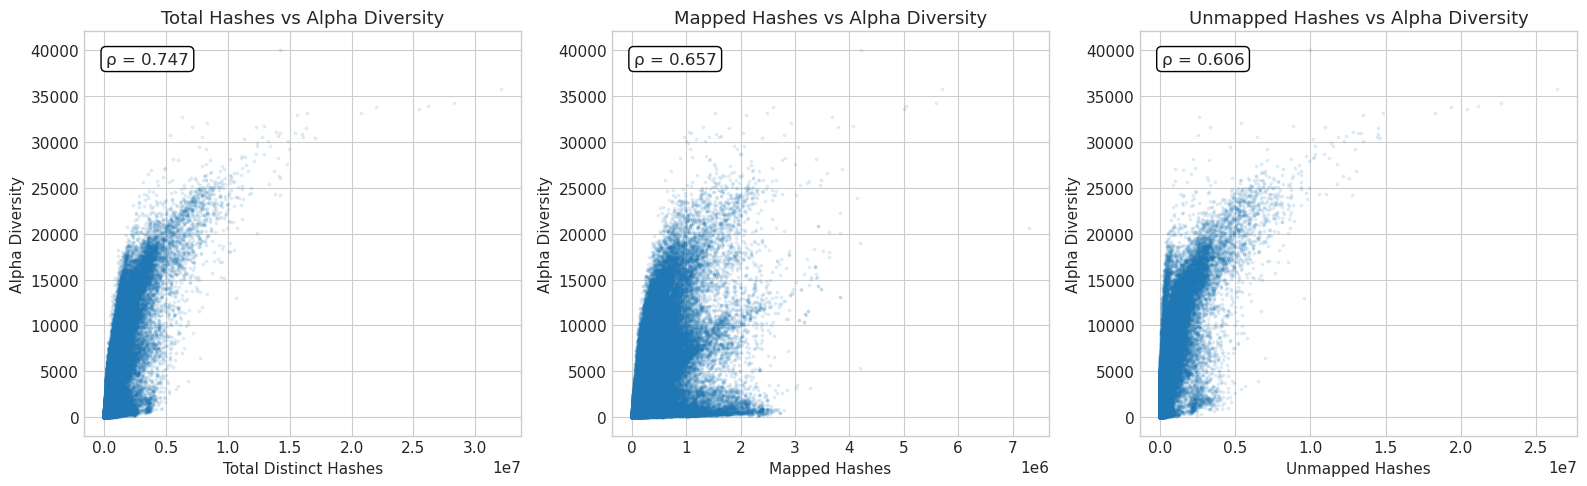

Figure saved: hash_types_vs_alpha_diversity.png

Interpretation: If mapped hashes correlate BETTER with alpha diversity than total hashes,
this supports the idea that unmapped hashes (dark matter) dilute the diversity signal.


In [80]:
# Key insight: Does alpha diversity correlate better with MAPPED hashes than TOTAL hashes?
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Total hashes vs alpha diversity
ax = axes[0]
ax.scatter(df_dmi['total_distinct_hashes'], df_dmi['alpha_diversity'], alpha=0.1, s=3)
r, p = spearmanr(df_dmi['total_distinct_hashes'], df_dmi['alpha_diversity'])
ax.text(0.05, 0.95, f'ρ = {r:.3f}', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white'))
ax.set_xlabel('Total Distinct Hashes')
ax.set_ylabel('Alpha Diversity')
ax.set_title('Total Hashes vs Alpha Diversity')

# Mapped hashes vs alpha diversity
ax = axes[1]
ax.scatter(df_dmi['mapped_hashes'], df_dmi['alpha_diversity'], alpha=0.1, s=3)
r, p = spearmanr(df_dmi['mapped_hashes'], df_dmi['alpha_diversity'])
ax.text(0.05, 0.95, f'ρ = {r:.3f}', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white'))
ax.set_xlabel('Mapped Hashes')
ax.set_ylabel('Alpha Diversity')
ax.set_title('Mapped Hashes vs Alpha Diversity')

# Unmapped hashes vs alpha diversity
ax = axes[2]
ax.scatter(df_dmi['unmapped_hashes'], df_dmi['alpha_diversity'], alpha=0.1, s=3)
r, p = spearmanr(df_dmi['unmapped_hashes'], df_dmi['alpha_diversity'])
ax.text(0.05, 0.95, f'ρ = {r:.3f}', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white'))
ax.set_xlabel('Unmapped Hashes')
ax.set_ylabel('Alpha Diversity')
ax.set_title('Unmapped Hashes vs Alpha Diversity')

plt.tight_layout()
plt.savefig('hash_types_vs_alpha_diversity.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved: hash_types_vs_alpha_diversity.png")
print("\nInterpretation: If mapped hashes correlate BETTER with alpha diversity than total hashes,")
print("this supports the idea that unmapped hashes (dark matter) dilute the diversity signal.")

### 7.4 Quantifying Dark Matter's Contribution to Variance

In [81]:
# Can we explain more variance in diversity_per_mb by including DMI in a model?
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Prepare data (drop NaN)
model_df = df_dmi[['hashes_per_mb', 'diversity_per_mb', 'dmi']].dropna()

X_simple = model_df[['hashes_per_mb']].values
X_with_dmi = model_df[['hashes_per_mb', 'dmi']].values
y = model_df['diversity_per_mb'].values

# Model 1: diversity_per_mb ~ hashes_per_mb
model_simple = LinearRegression()
model_simple.fit(X_simple, y)
y_pred_simple = model_simple.predict(X_simple)
r2_simple = r2_score(y, y_pred_simple)

# Model 2: diversity_per_mb ~ hashes_per_mb + dmi
model_dmi = LinearRegression()
model_dmi.fit(X_with_dmi, y)
y_pred_dmi = model_dmi.predict(X_with_dmi)
r2_dmi = r2_score(y, y_pred_dmi)

print("Linear Model Comparison:")
print("=" * 60)
print(f"\nModel 1: diversity_per_mb ~ hashes_per_mb")
print(f"  R² = {r2_simple:.4f}")
print(f"  Coefficient: {model_simple.coef_[0]:.6f}")

print(f"\nModel 2: diversity_per_mb ~ hashes_per_mb + dmi")
print(f"  R² = {r2_dmi:.4f}")
print(f"  Coefficients: hashes_per_mb={model_dmi.coef_[0]:.6f}, dmi={model_dmi.coef_[1]:.6f}")

print(f"\n  ΔR² = {r2_dmi - r2_simple:.4f}")
print(f"  Adding DMI explains {100*(r2_dmi - r2_simple):.2f}% additional variance")

if model_dmi.coef_[1] < 0:
    print(f"\n  → DMI coefficient is NEGATIVE, meaning higher DMI → lower diversity_per_mb")
    print(f"    This SUPPORTS the hypothesis that dark matter dilutes diversity signal.")
else:
    print(f"\n  → DMI coefficient is POSITIVE, unexpected result.")

Linear Model Comparison:

Model 1: diversity_per_mb ~ hashes_per_mb
  R² = 0.3548
  Coefficient: 0.005231

Model 2: diversity_per_mb ~ hashes_per_mb + dmi
  R² = 0.3557
  Coefficients: hashes_per_mb=0.005298, dmi=-0.046478

  ΔR² = 0.0009
  Adding DMI explains 0.09% additional variance

  → DMI coefficient is NEGATIVE, meaning higher DMI → lower diversity_per_mb
    This SUPPORTS the hypothesis that dark matter dilutes diversity signal.


## 8. DMI Per Mb Analysis (Alternative Normalization)

The standard DMI is a proportion (unmapped/total). This section explores an alternative: **unmapped hashes per Mb**, which normalizes by sample size rather than total hash count.

This may reveal different patterns, especially for samples with varying sequencing depths.

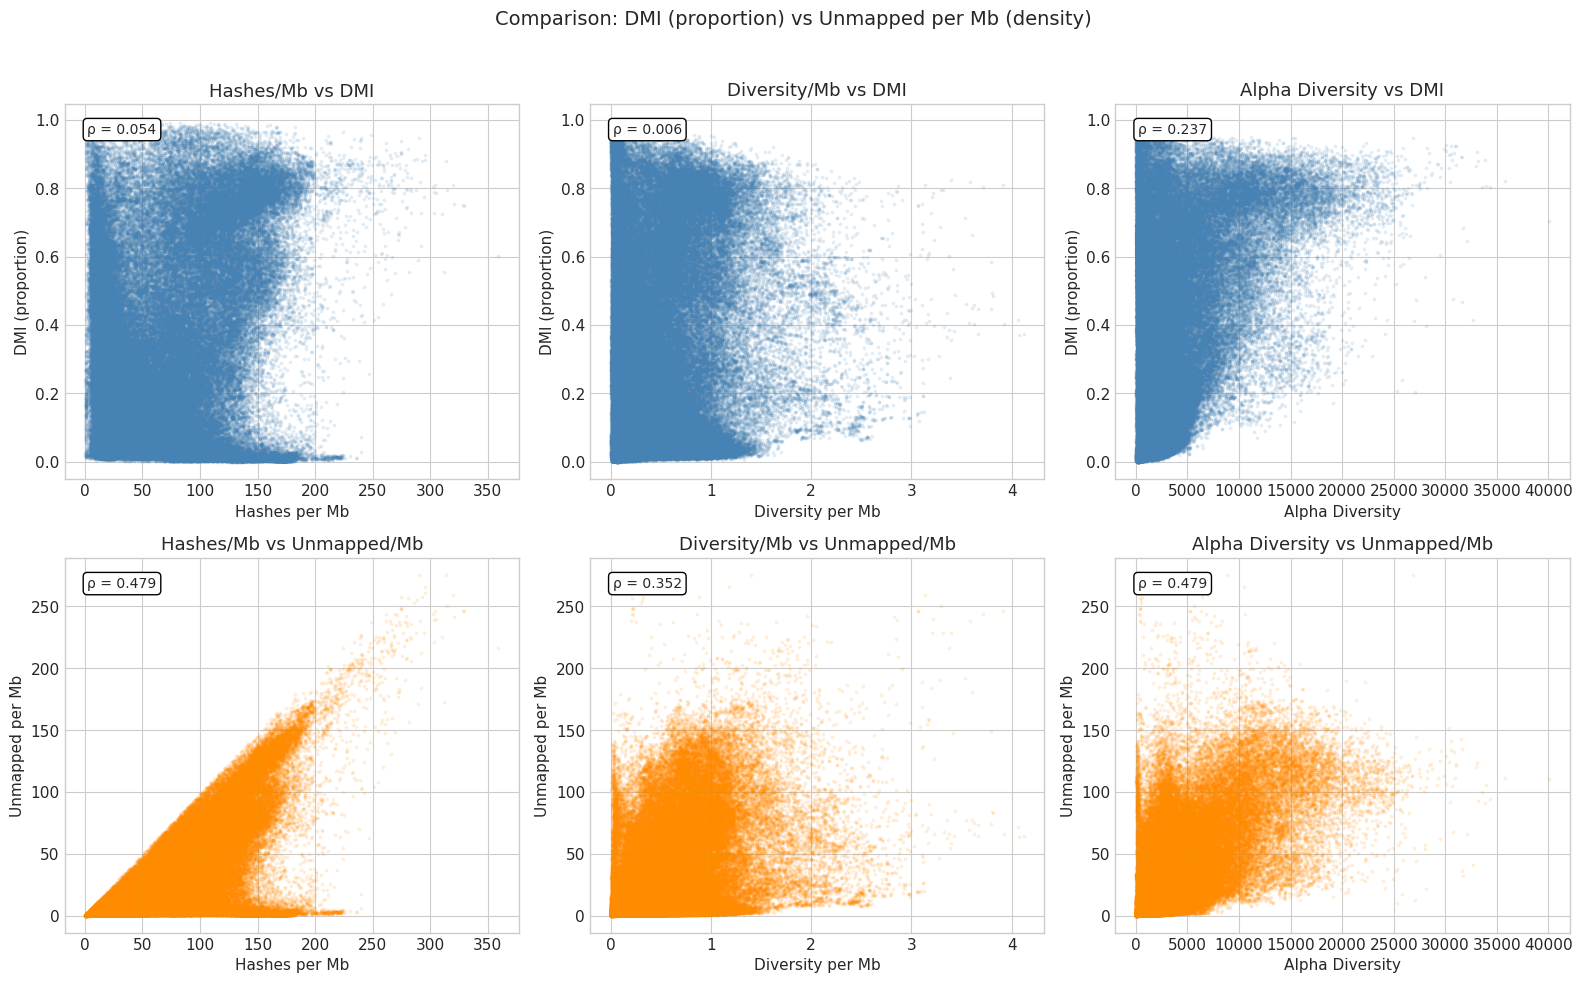

Figure saved: dmi_vs_unmapped_per_mb_comparison.png


In [82]:
# Compare original DMI (proportion) vs unmapped_per_mb (density)
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Row 1: Original DMI comparisons
ax = axes[0, 0]
ax.scatter(df_dmi['hashes_per_mb'], df_dmi['dmi'], alpha=0.1, s=3, c='steelblue')
r, p = spearmanr(df_dmi['hashes_per_mb'], df_dmi['dmi'])
ax.text(0.05, 0.95, f'ρ = {r:.3f}', transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white'))
ax.set_xlabel('Hashes per Mb')
ax.set_ylabel('DMI (proportion)')
ax.set_title('Hashes/Mb vs DMI')

ax = axes[0, 1]
ax.scatter(df_dmi['diversity_per_mb'], df_dmi['dmi'], alpha=0.1, s=3, c='steelblue')
r, p = spearmanr(df_dmi['diversity_per_mb'], df_dmi['dmi'])
ax.text(0.05, 0.95, f'ρ = {r:.3f}', transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white'))
ax.set_xlabel('Diversity per Mb')
ax.set_ylabel('DMI (proportion)')
ax.set_title('Diversity/Mb vs DMI')

ax = axes[0, 2]
ax.scatter(df_dmi['alpha_diversity'], df_dmi['dmi'], alpha=0.1, s=3, c='steelblue')
r, p = spearmanr(df_dmi['alpha_diversity'], df_dmi['dmi'])
ax.text(0.05, 0.95, f'ρ = {r:.3f}', transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white'))
ax.set_xlabel('Alpha Diversity')
ax.set_ylabel('DMI (proportion)')
ax.set_title('Alpha Diversity vs DMI')

# Row 2: Unmapped per Mb comparisons
ax = axes[1, 0]
ax.scatter(df_dmi['hashes_per_mb'], df_dmi['unmapped_per_mb'], alpha=0.1, s=3, c='darkorange')
r, p = spearmanr(df_dmi['hashes_per_mb'], df_dmi['unmapped_per_mb'])
ax.text(0.05, 0.95, f'ρ = {r:.3f}', transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white'))
ax.set_xlabel('Hashes per Mb')
ax.set_ylabel('Unmapped per Mb')
ax.set_title('Hashes/Mb vs Unmapped/Mb')

ax = axes[1, 1]
ax.scatter(df_dmi['diversity_per_mb'], df_dmi['unmapped_per_mb'], alpha=0.1, s=3, c='darkorange')
r, p = spearmanr(df_dmi['diversity_per_mb'], df_dmi['unmapped_per_mb'])
ax.text(0.05, 0.95, f'ρ = {r:.3f}', transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white'))
ax.set_xlabel('Diversity per Mb')
ax.set_ylabel('Unmapped per Mb')
ax.set_title('Diversity/Mb vs Unmapped/Mb')

ax = axes[1, 2]
ax.scatter(df_dmi['alpha_diversity'], df_dmi['unmapped_per_mb'], alpha=0.1, s=3, c='darkorange')
r, p = spearmanr(df_dmi['alpha_diversity'], df_dmi['unmapped_per_mb'])
ax.text(0.05, 0.95, f'ρ = {r:.3f}', transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white'))
ax.set_xlabel('Alpha Diversity')
ax.set_ylabel('Unmapped per Mb')
ax.set_title('Alpha Diversity vs Unmapped/Mb')

plt.suptitle('Comparison: DMI (proportion) vs Unmapped per Mb (density)', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('dmi_vs_unmapped_per_mb_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved: dmi_vs_unmapped_per_mb_comparison.png")

In [83]:
# Hash-Diversity plots colored by UNMAPPED_PER_MB instead of DMI
def plot_organism_hash_diversity_unmapped(df, organism, ax):
    """Plot hash density vs diversity colored by unmapped_per_mb."""
    subset = df[df['organism'] == organism].copy()
    
    if len(subset) == 0:
        return None
    
    # Use percentile-based color scaling for better visualization
    vmin = subset['unmapped_per_mb'].quantile(0.05)
    vmax = subset['unmapped_per_mb'].quantile(0.95)
    
    scatter = ax.scatter(subset['hashes_per_mb'], subset['diversity_per_mb'], 
                        c=subset['unmapped_per_mb'], cmap='RdYlBu_r', 
                        alpha=0.6, s=10, vmin=vmin, vmax=vmax)
    
    # Add regression line
    x = subset['hashes_per_mb'].values
    y = subset['diversity_per_mb'].values
    mask = ~(np.isnan(x) | np.isnan(y))
    x_clean, y_clean = x[mask], y[mask]
    
    if len(x_clean) > 2:
        slope, intercept, r_value, _, _ = stats.linregress(x_clean, y_clean)
        x_line = np.linspace(x_clean.min(), x_clean.max(), 100)
        ax.plot(x_line, slope * x_line + intercept, 'r-', linewidth=2, alpha=0.8)
        
        r_spearman, _ = spearmanr(x_clean, y_clean)
        stats_text = f'n={len(subset):,}\nr={r_value:.3f}\nρ={r_spearman:.3f}'
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=8,
                verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_xlabel('Hashes per Mb')
    ax.set_ylabel('Diversity per Mb')
    ax.set_title(organism)
    
    return scatter, vmin, vmax

# Create figure
n_cols = 3
n_rows = (len(available_organisms) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
axes = axes.flatten()

for idx, organism in enumerate(available_organisms):
    result = plot_organism_hash_diversity_unmapped(df_dmi, organism, axes[idx])

# Hide unused axes
for idx in range(len(available_organisms), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Hash-Diversity Correlation by Organism (Colored by Unmapped per Mb)', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('hash_diversity_by_organism_unmapped_per_mb.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved: hash_diversity_by_organism_unmapped_per_mb.png")


Figure saved: hash_diversity_by_organism_unmapped_per_mb.png


In [84]:
# Summary comparison of the two normalization approaches
print("\n" + "="*80)
print("COMPARISON: DMI (proportion) vs Unmapped per Mb (density)")
print("="*80)

print("\nCorrelation with key variables:")
print("-"*60)

for var in ['hashes_per_mb', 'diversity_per_mb', 'alpha_diversity']:
    r_dmi, _ = spearmanr(df_dmi['dmi'], df_dmi[var])
    r_unmapped, _ = spearmanr(df_dmi['unmapped_per_mb'], df_dmi[var])
    print(f"{var:25} DMI: ρ={r_dmi:+.4f}   Unmapped/Mb: ρ={r_unmapped:+.4f}")

print("\n\nInterpretation:")
print("-"*60)
print("DMI (proportion): Captures the FRACTION of dark matter in each sample")
print("  - Independent of sample size")
print("  - Better for comparing relative dark matter content")
print("")
print("Unmapped per Mb (density): Captures the AMOUNT of dark matter per unit size")
print("  - Analogous to hashes_per_mb")
print("  - Better for understanding absolute dark matter contribution")
print("  - More directly comparable to hashes_per_mb for the outlier hypothesis")


COMPARISON: DMI (proportion) vs Unmapped per Mb (density)

Correlation with key variables:
------------------------------------------------------------
hashes_per_mb             DMI: ρ=+0.0541   Unmapped/Mb: ρ=+0.4788
diversity_per_mb          DMI: ρ=+0.0059   Unmapped/Mb: ρ=+0.3517
alpha_diversity           DMI: ρ=+0.2367   Unmapped/Mb: ρ=+0.4788


Interpretation:
------------------------------------------------------------
DMI (proportion): Captures the FRACTION of dark matter in each sample
  - Independent of sample size
  - Better for comparing relative dark matter content

Unmapped per Mb (density): Captures the AMOUNT of dark matter per unit size
  - Analogous to hashes_per_mb
  - Better for understanding absolute dark matter contribution
  - More directly comparable to hashes_per_mb for the outlier hypothesis


## 9. Outlier Metadata Enrichment Analysis

Since DMI doesn't consistently explain the outliers across all organisms, this section investigates what **other metadata variables** characterize the outlier samples (high hashes per Mb, low diversity per Mb).

We'll test for enrichment of categorical variables and differences in continuous variables between outliers and normal samples.

In [85]:
# First, identify outliers across ALL samples (not just per organism)
df_global_outliers = identify_outliers(df_dmi, 'hashes_per_mb', 'diversity_per_mb', residual_threshold=2)

n_outliers_global = df_global_outliers['is_outlier'].sum()
n_normal_global = (~df_global_outliers['is_outlier']).sum()

print("Global Outlier Identification")
print("="*60)
print(f"Definition: Samples with standardized residual < -2")
print(f"  (Much lower diversity than expected given their hash density)")
print(f"")
print(f"Total samples: {len(df_global_outliers):,}")
print(f"Outliers: {n_outliers_global:,} ({100*n_outliers_global/len(df_global_outliers):.1f}%)")
print(f"Normal: {n_normal_global:,} ({100*n_normal_global/len(df_global_outliers):.1f}%)")

Global Outlier Identification
Definition: Samples with standardized residual < -2
  (Much lower diversity than expected given their hash density)

Total samples: 192,893
Outliers: 7,090 (3.7%)
Normal: 185,803 (96.3%)


In [86]:
def test_categorical_enrichment(df, column, min_category_count=100):
    """
    Test if outliers are enriched for specific categories of a variable.
    
    Returns a dataframe with enrichment statistics for each category.
    """
    results = []
    
    # Get counts
    n_outliers_total = df['is_outlier'].sum()
    n_normal_total = (~df['is_outlier']).sum()
    
    # Get categories with sufficient counts
    category_counts = df[column].value_counts()
    categories = category_counts[category_counts >= min_category_count].index.tolist()
    
    for category in categories:
        subset = df[df[column] == category]
        n_outliers_cat = subset['is_outlier'].sum()
        n_normal_cat = (~subset['is_outlier']).sum()
        
        # Proportion of outliers in this category
        pct_outliers_cat = 100 * n_outliers_cat / len(subset) if len(subset) > 0 else 0
        
        # Overall outlier proportion
        pct_outliers_overall = 100 * n_outliers_total / len(df)
        
        # Enrichment ratio
        enrichment = pct_outliers_cat / pct_outliers_overall if pct_outliers_overall > 0 else 0
        
        # Fisher's exact test (for small counts) or chi-square
        # Contingency table: [[outliers_in_cat, outliers_not_in_cat], [normal_in_cat, normal_not_in_cat]]
        contingency = [
            [n_outliers_cat, n_outliers_total - n_outliers_cat],
            [n_normal_cat, n_normal_total - n_normal_cat]
        ]
        
        try:
            if min(n_outliers_cat, n_normal_cat) < 5:
                _, pvalue = fisher_exact(contingency)
            else:
                _, pvalue, _, _ = chi2_contingency(contingency)
        except:
            pvalue = 1.0
        
        results.append({
            'category': category,
            'n_total': len(subset),
            'n_outliers': n_outliers_cat,
            'n_normal': n_normal_cat,
            'pct_outliers': pct_outliers_cat,
            'enrichment': enrichment,
            'pvalue': pvalue
        })
    
    result_df = pd.DataFrame(results)
    result_df['significant'] = result_df['pvalue'] < 0.05
    
    return result_df.sort_values('enrichment', ascending=False)

In [87]:
# Test categorical variables for outlier enrichment
categorical_vars = ['organism', 'platform', 'biome', 'librarysource', 'librarylayout', 
                    'libraryselection', 'center_name', 'instrument']
categorical_vars = [c for c in categorical_vars if c in df_global_outliers.columns]

print("\n" + "="*100)
print("CATEGORICAL VARIABLE ENRICHMENT IN OUTLIERS")
print("="*100)
print("\nEnrichment > 1 means outliers are OVER-represented in that category")
print("Enrichment < 1 means outliers are UNDER-represented")

all_enrichment_results = {}

for var in categorical_vars:
    print(f"\n\n{'='*80}")
    print(f"Variable: {var}")
    print(f"{'='*80}")
    
    enrichment_df = test_categorical_enrichment(df_global_outliers, var, min_category_count=100)
    all_enrichment_results[var] = enrichment_df
    
    # Show top enriched and top depleted
    print(f"\nTop 5 ENRICHED (outliers over-represented):")
    print("-"*80)
    for _, row in enrichment_df.head(5).iterrows():
        sig = '*' if row['significant'] else ''
        print(f"  {row['category'][:40]:<40} enrichment={row['enrichment']:.2f}x  {row['pct_outliers']:.1f}% outliers  (n={row['n_total']:,}) {sig}")
    
    print(f"\nTop 5 DEPLETED (outliers under-represented):")
    print("-"*80)
    for _, row in enrichment_df.tail(5).iterrows():
        sig = '*' if row['significant'] else ''
        print(f"  {row['category'][:40]:<40} enrichment={row['enrichment']:.2f}x  {row['pct_outliers']:.1f}% outliers  (n={row['n_total']:,}) {sig}")


CATEGORICAL VARIABLE ENRICHMENT IN OUTLIERS

Enrichment > 1 means outliers are OVER-represented in that category
Enrichment < 1 means outliers are UNDER-represented


Variable: organism

Top 5 ENRICHED (outliers over-represented):
--------------------------------------------------------------------------------
  placenta metagenome                      enrichment=27.21x  100.0% outliers  (n=108) *
  eye metagenome                           enrichment=25.92x  95.3% outliers  (n=444) *
  blood metagenome                         enrichment=25.69x  94.4% outliers  (n=108) *
  metagenomes                              enrichment=18.85x  69.3% outliers  (n=127) *
  human sputum metagenome                  enrichment=17.24x  63.4% outliers  (n=191) *

Top 5 DEPLETED (outliers under-represented):
--------------------------------------------------------------------------------
  peat metagenome                          enrichment=0.00x  0.0% outliers  (n=822) *
  dust metagenome                

In [88]:
# Visualize enrichment for key variables
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

plot_vars = ['organism', 'biome', 'librarysource', 'platform']
plot_vars = [v for v in plot_vars if v in all_enrichment_results]

for idx, var in enumerate(plot_vars[:4]):
    ax = axes[idx]
    data = all_enrichment_results[var]
    
    # Take top 10 enriched and top 10 depleted
    top_enriched = data.head(10)
    top_depleted = data.tail(10)
    plot_data = pd.concat([top_enriched, top_depleted]).drop_duplicates()
    plot_data = plot_data.sort_values('enrichment', ascending=True)
    
    # Color by enrichment
    colors = ['red' if e > 1 else 'blue' for e in plot_data['enrichment']]
    
    y_pos = range(len(plot_data))
    ax.barh(y_pos, plot_data['enrichment'], color=colors, alpha=0.7, edgecolor='black')
    ax.axvline(x=1, color='gray', linestyle='--', linewidth=2)
    ax.set_yticks(y_pos)
    ax.set_yticklabels([f"{c[:35]}" for c in plot_data['category']], fontsize=8)
    ax.set_xlabel('Enrichment Ratio')
    ax.set_title(f'Outlier Enrichment by {var}')

plt.tight_layout()
plt.savefig('outlier_enrichment_categorical.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved: outlier_enrichment_categorical.png")

Figure saved: outlier_enrichment_categorical.png


In [89]:
# Test continuous variables for differences between outliers and normal samples
continuous_vars = ['dmi', 'unmapped_per_mb', 'mapped_per_mb', 'alpha_diversity', 
                   'total_distinct_hashes', 'avgspotlen', 'mbytes']
continuous_vars = [c for c in continuous_vars if c in df_global_outliers.columns]

print("\n" + "="*100)
print("CONTINUOUS VARIABLE DIFFERENCES: OUTLIERS vs NORMAL")
print("="*100)

continuous_results = []

for var in continuous_vars:
    outlier_vals = df_global_outliers[df_global_outliers['is_outlier']][var].dropna()
    normal_vals = df_global_outliers[~df_global_outliers['is_outlier']][var].dropna()
    
    # Mann-Whitney U test
    stat, pvalue = stats.mannwhitneyu(outlier_vals, normal_vals, alternative='two-sided')
    
    result = {
        'variable': var,
        'outlier_median': outlier_vals.median(),
        'normal_median': normal_vals.median(),
        'difference': outlier_vals.median() - normal_vals.median(),
        'pct_difference': 100 * (outlier_vals.median() - normal_vals.median()) / normal_vals.median() if normal_vals.median() != 0 else np.nan,
        'pvalue': pvalue,
        'significant': pvalue < 0.05
    }
    continuous_results.append(result)

continuous_df = pd.DataFrame(continuous_results)
continuous_df = continuous_df.sort_values('pvalue')

print("\n{:<25} {:>12} {:>12} {:>10} {:>12} {:>6}".format(
    'Variable', 'Outlier Med', 'Normal Med', '% Diff', 'p-value', 'Sig'))
print("-"*90)

for _, row in continuous_df.iterrows():
    sig = '***' if row['pvalue'] < 0.001 else ('**' if row['pvalue'] < 0.01 else ('*' if row['pvalue'] < 0.05 else ''))
    print(f"{row['variable']:<25} {row['outlier_median']:>12.2f} {row['normal_median']:>12.2f} {row['pct_difference']:>+9.1f}% {row['pvalue']:>12.2e} {sig:>6}")


CONTINUOUS VARIABLE DIFFERENCES: OUTLIERS vs NORMAL

Variable                   Outlier Med   Normal Med     % Diff      p-value    Sig
------------------------------------------------------------------------------------------
dmi                               0.01         0.19     -93.8%     0.00e+00    ***
unmapped_per_mb                   1.75         5.87     -70.1%     0.00e+00    ***
mapped_per_mb                   145.51        37.40    +289.1%     0.00e+00    ***
alpha_diversity                 411.00      2303.00     -82.2%     0.00e+00    ***
total_distinct_hashes        830667.50    289380.00    +187.1%     0.00e+00    ***
mbytes                         1900.00      2159.00     -12.0%     6.77e-40    ***
avgspotlen                      300.00       300.00      +0.0%     9.71e-18    ***


In [90]:
# Visualize continuous variable differences
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, var in enumerate(continuous_vars[:6]):
    ax = axes[idx]
    
    outliers = df_global_outliers[df_global_outliers['is_outlier']][var]
    normal = df_global_outliers[~df_global_outliers['is_outlier']][var]
    
    # Box plots
    bp = ax.boxplot([normal.dropna(), outliers.dropna()], 
                   labels=['Normal', 'Outlier'],
                   patch_artist=True)
    bp['boxes'][0].set_facecolor('steelblue')
    bp['boxes'][1].set_facecolor('coral')
    
    # Add stats
    row = continuous_df[continuous_df['variable'] == var].iloc[0]
    sig = '***' if row['pvalue'] < 0.001 else ('**' if row['pvalue'] < 0.01 else ('*' if row['pvalue'] < 0.05 else 'ns'))
    ax.text(0.5, 0.95, f'p = {row["pvalue"]:.2e} {sig}', 
            transform=ax.transAxes, ha='center', va='top', fontsize=10)
    
    ax.set_ylabel(var)
    ax.set_title(f'{var}\nOutlier: {row["outlier_median"]:.2f}, Normal: {row["normal_median"]:.2f}')

plt.suptitle('Continuous Variable Comparison: Outliers vs Normal Samples', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('outlier_continuous_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved: outlier_continuous_comparison.png")

Figure saved: outlier_continuous_comparison.png


In [91]:
# Summary of outlier characteristics
print("\n" + "="*100)
print("SUMMARY: WHAT CHARACTERIZES THE OUTLIERS?")
print("="*100)

print("\n1. CATEGORICAL ENRICHMENT (significant, enrichment > 1.5x):")
print("-"*70)
for var, data in all_enrichment_results.items():
    enriched = data[(data['significant']) & (data['enrichment'] > 1.5)]
    if len(enriched) > 0:
        print(f"\n{var}:")
        for _, row in enriched.head(5).iterrows():
            print(f"  - {row['category'][:50]}: {row['enrichment']:.2f}x enrichment")

print("\n\n2. CONTINUOUS VARIABLE DIFFERENCES (significant):")
print("-"*70)
sig_continuous = continuous_df[continuous_df['significant']]
for _, row in sig_continuous.iterrows():
    direction = "HIGHER" if row['difference'] > 0 else "LOWER"
    print(f"  - {row['variable']}: Outliers are {direction} ({row['pct_difference']:+.1f}%)")

print("\n\n3. KEY INSIGHTS:")
print("-"*70)
print("""Based on the enrichment analysis, outliers (samples with high hash density
but low diversity) may be characterized by specific organisms, biomes, or
technical factors. Review the enrichment tables above to identify which
metadata variables best explain the outlier pattern.""")


SUMMARY: WHAT CHARACTERIZES THE OUTLIERS?

1. CATEGORICAL ENRICHMENT (significant, enrichment > 1.5x):
----------------------------------------------------------------------

organism:
  - placenta metagenome: 27.21x enrichment
  - eye metagenome: 25.92x enrichment
  - blood metagenome: 25.69x enrichment
  - metagenomes: 18.85x enrichment
  - human sputum metagenome: 17.24x enrichment

biome:
  - WWF_TEW_BIOME_02: 5.08x enrichment
  - WWF_TEW_BIOME_14: 2.62x enrichment
  - unknown: 1.69x enrichment
  - WWF_TEW_BIOME_08: 1.62x enrichment

center_name:
  - INSELSPITAL: 25.84x enrichment
  - DALHOUSIE UNIVERSITY: 18.32x enrichment
  - SIR RUN RUN SHAW HOSPITAL, SCHOOL OF MEDICINE, ZHE: 17.62x enrichment
  - WAGENINGEN UNIVERSITY & RESEARCH: 16.82x enrichment
  - PENN STATE COLLEGE OF MEDICINE: 15.49x enrichment

instrument:
  - Illumina HiSeq 4000: 1.62x enrichment


2. CONTINUOUS VARIABLE DIFFERENCES (significant):
----------------------------------------------------------------------
 

## 10. Summary and Conclusions

In [92]:
print("="*80)
print("ANALYSIS SUMMARY")
print("="*80)

print(f"\n1. DATASET OVERVIEW")
print(f"   - Total samples analyzed: {len(df_dmi):,}")
print(f"   - Platform filter: {PLATFORM_FILTER}")
print(f"   - Organisms represented: {df_dmi['organism'].nunique():,}")

print(f"\n2. DMI DISTRIBUTION")
print(f"   - Mean DMI: {df_dmi['dmi'].mean():.4f}")
print(f"   - Median DMI: {df_dmi['dmi'].median():.4f}")
print(f"   - Samples with DMI > 0.5: {(df_dmi['dmi'] > 0.5).sum():,} ({100*(df_dmi['dmi'] > 0.5).mean():.1f}%)")

print(f"\n3. KEY CORRELATIONS")
r_hash, _ = spearmanr(df_dmi['dmi'], df_dmi['hashes_per_mb'])
r_div, _ = spearmanr(df_dmi['dmi'], df_dmi['diversity_per_mb'])
print(f"   - DMI vs Hashes/Mb: ρ = {r_hash:.4f}")
print(f"   - DMI vs Diversity/Mb: ρ = {r_div:.4f}")

print(f"\n4. TOP DARK MATTER ORGANISMS (median DMI, n>=100):")
for i, (_, row) in enumerate(top10_dmi.head(5).iterrows()):
    print(f"   {i+1}. {row['organism']}: {row['median_dmi']:.4f}")

print(f"\n5. OUTLIER ANALYSIS")
n_sig = outlier_df['significant'].sum() if 'outlier_df' in dir() else 0
print(f"   - Organisms where outliers have significantly higher DMI: {n_sig}/{len(outlier_df)}")

print(f"\n6. MODEL COMPARISON")
print(f"   - R² without DMI: {r2_simple:.4f}")
print(f"   - R² with DMI: {r2_dmi:.4f}")
print(f"   - Variance explained by DMI: {100*(r2_dmi - r2_simple):.2f}%")

print("\n" + "="*80)
print("HYPOTHESIS EVALUATION")
print("="*80)
print("""
The hypothesis that Dark Matter Index explains the multi-modal distribution
of alpha diversity vs hash density can be evaluated by examining:

1. Do outliers (samples below the regression line) have higher DMI?
2. Does including DMI in a predictive model improve variance explained?
3. Do high-DMI organisms show the expected pattern?
4. What other metadata variables characterize the outliers?

Review the figures and statistics above to draw conclusions.
""")

ANALYSIS SUMMARY

1. DATASET OVERVIEW
   - Total samples analyzed: 192,893
   - Platform filter: ['ILLUMINA']
   - Organisms represented: 1,110

2. DMI DISTRIBUTION
   - Mean DMI: 0.2830
   - Median DMI: 0.1744
   - Samples with DMI > 0.5: 45,029 (23.3%)

3. KEY CORRELATIONS
   - DMI vs Hashes/Mb: ρ = 0.0541
   - DMI vs Diversity/Mb: ρ = 0.0059

4. TOP DARK MATTER ORGANISMS (median DMI, n>=100):
   1. termite gut metagenome: 0.9164
   2. museum specimen metagenome: 0.8186
   3. wetland metagenome: 0.8124
   4. human blood metagenome: 0.8015
   5. pond metagenome: 0.7807

5. OUTLIER ANALYSIS
   - Organisms where outliers have significantly higher DMI: 6/14

6. MODEL COMPARISON
   - R² without DMI: 0.3548
   - R² with DMI: 0.3557
   - Variance explained by DMI: 0.09%

HYPOTHESIS EVALUATION

The hypothesis that Dark Matter Index explains the multi-modal distribution
of alpha diversity vs hash density can be evaluated by examining:

1. Do outliers (samples below the regression line) have h

In [93]:
# List all generated figures
print("\nGenerated Figures:")
print("-" * 40)
import os
for f in sorted(os.listdir('.')):
    if f.endswith('.png'):
        print(f"  - {f}")


Generated Figures:
----------------------------------------
  - correlation_matrices.png
  - dmi_by_biome.png
  - dmi_by_platform.png
  - dmi_distribution_overview.png
  - dmi_vs_metrics_scatter.png
  - dmi_vs_unmapped_per_mb_comparison.png
  - hash_diversity_by_organism_dmi_colored.png
  - hash_diversity_by_organism_unmapped_per_mb.png
  - hash_types_vs_alpha_diversity.png
  - high_low_dmi_comparison.png
  - outlier_continuous_comparison.png
  - outlier_dmi_analysis.png
  - outlier_enrichment_categorical.png
  - top_bottom_organisms_dmi.png
  - unmapped_per_mb_vs_metrics_scatter.png


---

## Appendix: Running This Notebook

### Interactive Mode (Browser via X11)

```bash
# On your local machine, connect with X11 forwarding
ssh -X user@server

# Start Jupyter
jupyter notebook --no-browser --port=8888

# Or use Jupyter Lab
jupyter lab --no-browser --port=8888

# Then open the URL in your local browser
```

### Headless Mode (Command Line Execution)

```bash
# Execute and save outputs
jupyter nbconvert --to notebook --execute dmi_analysis.ipynb --output dmi_analysis_executed.ipynb

# Or convert to HTML for easy viewing
jupyter nbconvert --to html --execute dmi_analysis.ipynb --output dmi_analysis_report.html

# Or run as Python script
jupyter nbconvert --to script dmi_analysis.ipynb
python dmi_analysis.py
```

### Notes

- For headless execution, uncomment `matplotlib.use('Agg')` in the first code cell
- All figures are saved as PNG files in the working directory
- Modify `PARQUET_PATH` and `PLATFORM_FILTER` in Section 1 to customize analysis